# Adatforrás

## Linkek

https://www.semanticscholar.org/reader/e81657338e48b233c8c6019832e6670fa552adb4

https://archive.ics.uci.edu/dataset/372/htru2

https://www.kaggle.com/code/lucaspcarlini/predicting-pulsar-stars

https://www.utgjiu.ro/rev_ing/pdf/2022-2/07_Diaconu_TOWARDS%20A%20UNIFIED%202.pdf

https://bisa.ai/portofolio/detail/MzAzNg

## Adatok jellege

Az HTRU2 adatbázis a High Time Resolution Universe Survey során gyűjtött pulzárjelölt adatokat tartalmazza. A pulzárok gyorsan forgó neutroncsillagok, melyek rádiójelet bocsátanak ki, ezek periodikusan ismétlődnek, és földi teleszkópokkal észlelhetők. A jelöltek többsége azonban nem valódi pulzár, hanem zaj vagy rádiófrekvenciás interferencia következménye, így nehéz azonosítani a valódi pulzárokat. Az adatbázis 16259 hamis és 1639 valódi pulzár példát tartalmaz, amelyeket emberi annotátorok ellenőriztek.

# Python

## Importok

In [95]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from sklearn.decomposition import PCA
from factor_analyzer import Rotator
from sklearn.manifold import MDS, Isomap, TSNE
from factor_analyzer import FactorAnalyzer
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import gridspec
import math
from sklearn.manifold import LocallyLinearEmbedding
import umap

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## Saját függvények

A megjelenítéssel foglalkozó eljárások.

In [2]:
def grafikon_scatter_2d(data, n_rows=1, s=1):
    num_plots = len(data["figs"])
    n_cols = math.ceil(num_plots / n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 8))
    axes = axes.flatten() if num_plots > 1 else [axes]
    
    targets = [0, 1]
    colors = ['r', 'g']

    for idx, d in enumerate(data["figs"]):
        ax = axes[idx]
        ax.set_title(f'HTRU2 - 2D - {d["method"]} ({d["msg"]})', fontsize=16)
        ax.set_xlabel(data["x_label"])
        ax.set_ylabel(data["y_label"])
        for target, color in zip(targets, colors):
            indicesToKeep = data["data"]['class'] == target
            ax.scatter(data["data"].loc[indicesToKeep, d["x"]],
                       data["data"].loc[indicesToKeep, d["y"]],
                       c=color, s=s)
        ax.legend(targets)

    for i in range(len(data["figs"]), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

In [3]:
def grafikon_scatter_3d(data):
    num_figs = len(data["figs"])
    fig = plt.figure(figsize=(num_figs * 8, 8))
    axes = []

    for i in range(num_figs):
        ax = fig.add_subplot(1, num_figs, i + 1, projection='3d')
        axes.append(ax)

    targets = [0, 1]
    colors = ['r', 'g']

    for d in data["figs"]:
        ax = axes[d["id"]]
        ax.set_title(f'HTRU2 - 3D - {d["method"]} ({d["msg"]})', fontsize=16)
        ax.set_xlabel(data["x_label"])
        ax.set_ylabel(data["y_label"])
        ax.set_zlabel(data["z_label"])
        for target, color in zip(targets, colors):
            indicesToKeep = data["data"]['class'] == target
            ax.scatter(
                data["data"].loc[indicesToKeep, d["x"]], 
                data["data"].loc[indicesToKeep, d["y"]], 
                data["data"].loc[indicesToKeep, d["z"]], 
                c=color, 
                s=1, 
                label=f'{target}')
        ax.legend()

    plt.show()


In [4]:
def grafikon_scatter_forgathato_3d(data):
    num_figs = len(data["figs"])
    fig = make_subplots(rows=1, cols=num_figs, specs=[[{'type': 'scatter3d'}]*num_figs],
                        subplot_titles=[f'{d["method"]} ({d["msg"]})' for d in data["figs"]])
    
    targets = [0, 1]
    colors = ['red', 'green']

    for i, d in enumerate(data["figs"]):
        for target, color in zip(targets, colors):
            indicesToKeep = data["data"]['class'] == target
            fig.add_trace(
                go.Scatter3d(
                    x=data["data"].loc[indicesToKeep, d["x"]],
                    y=data["data"].loc[indicesToKeep, d["y"]],
                    z=data["data"].loc[indicesToKeep, d["z"]],
                    mode='markers',
                    marker=dict(size=1, color=color),
                    name=f'{target}',
                    legendgroup=f'{target}',
                    showlegend=(i == 0)
                ),
                row=1, col=i+1
            )
    
    layout_scenes = {}
    for i in range(1, num_figs + 1):
        scene_name = 'scene' if i == 1 else f'scene{i}'
        layout_scenes[scene_name] = dict(
            xaxis_title=data["x_label"],
            yaxis_title=data["y_label"],
            zaxis_title=data["z_label"]
        )

    fig.update_layout(
        height=600,
        width=600 * num_figs,
        title_text="HTRU2 - 3D Scatter Plots",
        **layout_scenes
    )

    fig.show()

In [5]:
def grafikon_rendezett(X, feature_cimkek):
    num_cols = 4
    num_rows = 2
    plots_per_fig = num_cols * num_rows

    for i, adat in enumerate(feature_cimkek):
        if i % plots_per_fig == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
            plt.style.use('ggplot')
            fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
            axs = axs.flatten()

        ax = axs[i % plots_per_fig]
        sorted_data = np.sort(X[adat].unique())
        sorted_data_999 = np.percentile(sorted_data, 99.0)
        sorted_data_01 = np.percentile(sorted_data, 1.0)

        ax.plot(range(len(sorted_data)), sorted_data, marker='o', linestyle='-', color='steelblue', alpha=0.7, markersize=3)
        ax.set_title(adat, fontsize=12)
        ax.set_xlabel('sorszám', fontsize=10)
        ax.set_ylabel('érték', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.axhline(y=X[adat].mean(), color='red', linestyle='--', label=f'Átlag: {X[adat].mean():.2f} mp')
        ax.axhline(y=X[adat].median(), color='green', linestyle='--', label=f'Medián: {X[adat].median():.2f} mp')
        ax.axhline(y=sorted_data_999, color='magenta', linestyle='--', label=f'99.9%: {sorted_data_999:.2f}')
        ax.axhline(y=sorted_data_01, color='blue', linestyle='--', label=f'0.1%: {sorted_data_01:.2f}')
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

In [6]:
def grafikon_eloszlas(X, feature_list):
    sns.set_style("whitegrid")
    sns.set_palette("muted")

    num_cols = 4
    num_rows = 2
    plots_per_fig = num_cols * num_rows

    for i, adat in enumerate(feature_list):
        if i % plots_per_fig == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
            axes = axes.flatten()

        ax = axes[i % plots_per_fig]
        sns.histplot(data=X, x=adat, kde=True, color='steelblue', ax=ax, bins=50)
        ax.set_title(f"{adat} eloszlás", fontsize=12)
        ax.set_xlabel(adat)
        ax.set_ylabel("Gyakoriság")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Adatok

## Betöltés

In [7]:
htru2 = fetch_ucirepo(id=372)

In [8]:
X = htru2.data.features
y = htru2.data.targets

## Adatok vizsgálata

In [9]:
len(X), len(y)

(17898, 17898)

In [10]:
hianyzo_ertekek = X.isnull().sum()
hianyzo_ertekek

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
dtype: int64

In [11]:
X.describe()

Profile_mean  Profile_stdev  Profile_skewness  Profile_kurtosis  \
count  17898.000000   17898.000000      17898.000000      17898.000000   
mean     111.079968      46.549532          0.477857          1.770279   
std       25.652935       6.843189          1.064040          6.167913   
min        5.812500      24.772042         -1.876011         -1.791886   
25%      100.929688      42.376018          0.027098         -0.188572   
50%      115.078125      46.947479          0.223240          0.198710   
75%      127.085938      51.023202          0.473325          0.927783   
max      192.617188      98.778911          8.069522         68.101622   

            DM_mean      DM_stdev   DM_skewness   DM_kurtosis  
count  17898.000000  17898.000000  17898.000000  17898.000000  
mean      12.614400     26.326515      8.303556    104.857709  
std       29.472897     19.470572      4.506092    106.514540  
min        0.213211      7.370432     -3.139270     -1.976976  
25%        1.923077     14.437332      5.781506     34.960504  
50%        2.801839     18.461316      8.433515     83.064556  
75%        5.464256     28.428104     10.702959    139.309330  
max      223.392141    110.642211     34.539844   1191.000837

A DM_mean, DM_kurtosis, Profile_kurtosis, Profile_skewness adatoknál gondolnám, hogy szükség lesz majd adattisztításra, mert itt a max értékek nagyon magasnak tűnnek. Elsősorban azt néztem, hogy a min-mean-max alapján hol látok nagyobb eltolódást.

In [12]:
feature_cimkek = list(X.columns)
print(feature_cimkek)

['Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis']


Profile_mean – A kvazár rádiófrekvenciás profiljának átlagos intenzitása, azaz az adott hullámforma középértéke.

Profile_stdev – A profil intenzitásának szórása, ami azt mutatja, mennyire ingadozik az érték az átlag körül.

Profile_skewness – A profil aszimmetriáját jelzi.

Profile_kurtosis – A profil csúcsosságát vagy laposságát mutatja az eloszlás normálishoz viszonyított alakja alapján.

DM_mean – A diszperziós mérték (Dispersion Measure) átlagos értéke, amely megmutatja, mennyi anyagon haladt át a jel.

DM_stdev – A diszperziós mérték szórása, azaz mennyire változó ez az érték a mérések során.

DM_skewness – A diszperziós mérték eloszlásának aszimmetriáját mutatja, hasonlóan a profilhoz.

DM_kurtosis – A diszperziós mérték eloszlásának csúcsosságát vagy laposságát jellemzi.

In [13]:
X.head()

Profile_mean  Profile_stdev  Profile_skewness  Profile_kurtosis   DM_mean  \
0    140.562500      55.683782         -0.234571         -0.699648  3.199833   
1    102.507812      58.882430          0.465318         -0.515088  1.677258   
2    103.015625      39.341649          0.323328          1.051164  3.121237   
3    136.750000      57.178449         -0.068415         -0.636238  3.642977   
4     88.726562      40.672225          0.600866          1.123492  1.178930   

    DM_stdev  DM_skewness  DM_kurtosis  
0  19.110426     7.975532    74.242225  
1  14.860146    10.576487   127.393580  
2  21.744669     7.735822    63.171909  
3  20.959280     6.896499    53.593661  
4  11.468720    14.269573   252.567306

A sorbarendezett egyedi adatokat rajzoltatom itt ki, hogy lássam milyen skálán helyezkednek el.

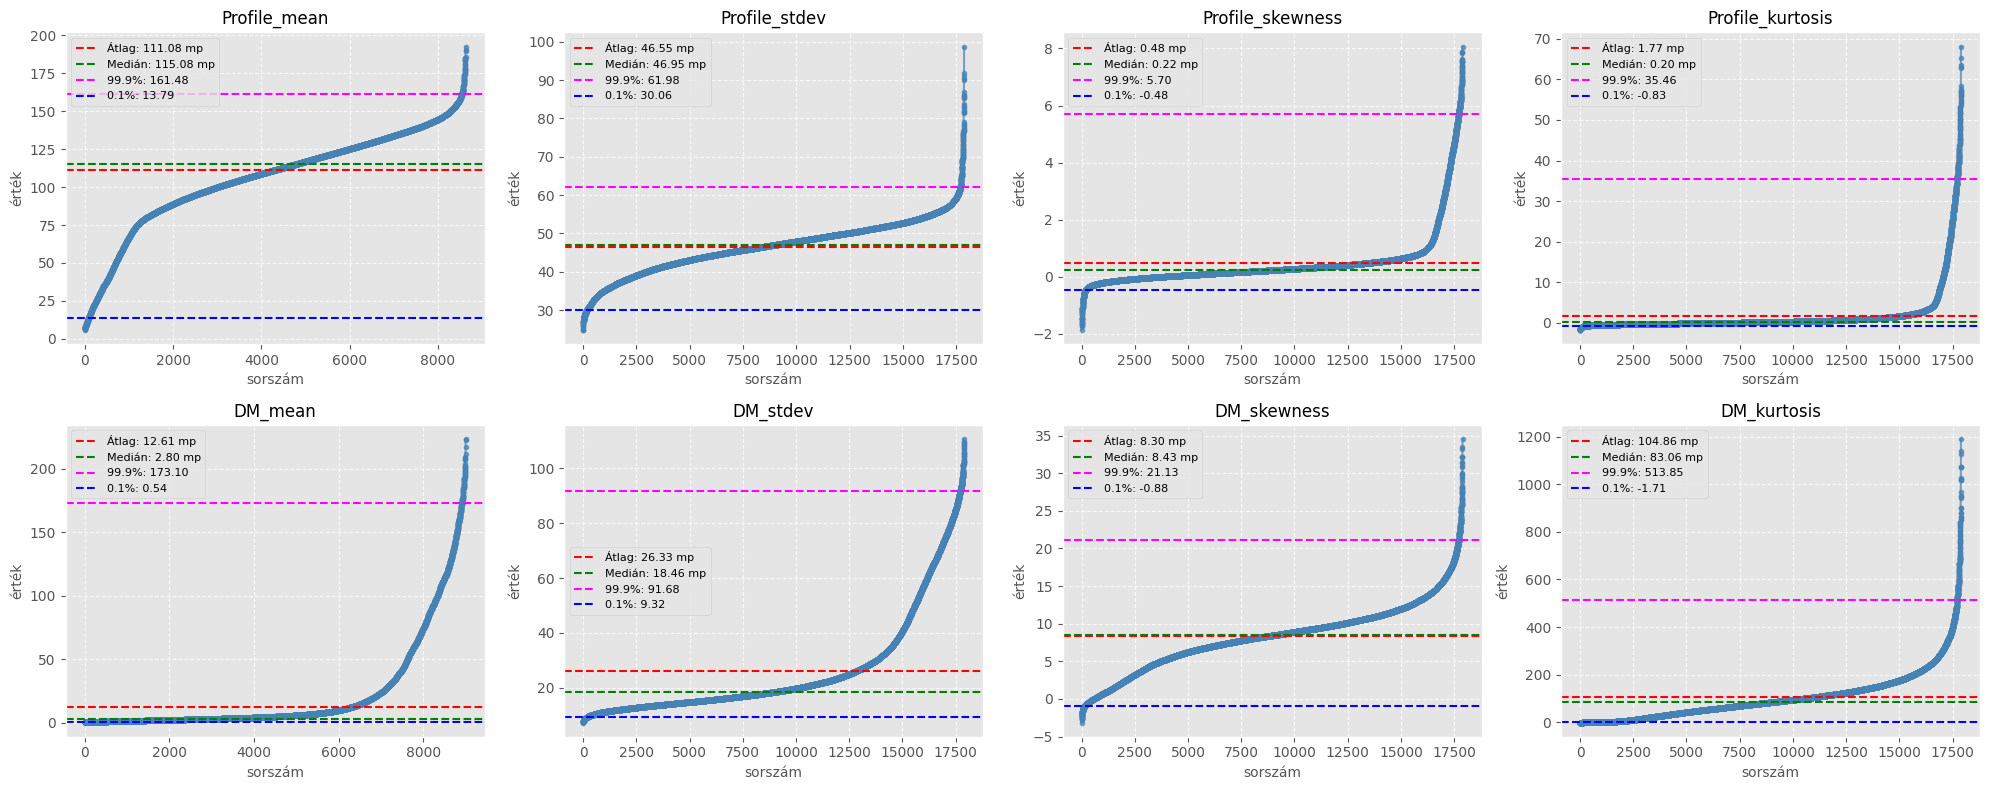

In [14]:
grafikon_rendezett(X, feature_cimkek)

Az adatok eloszlása.

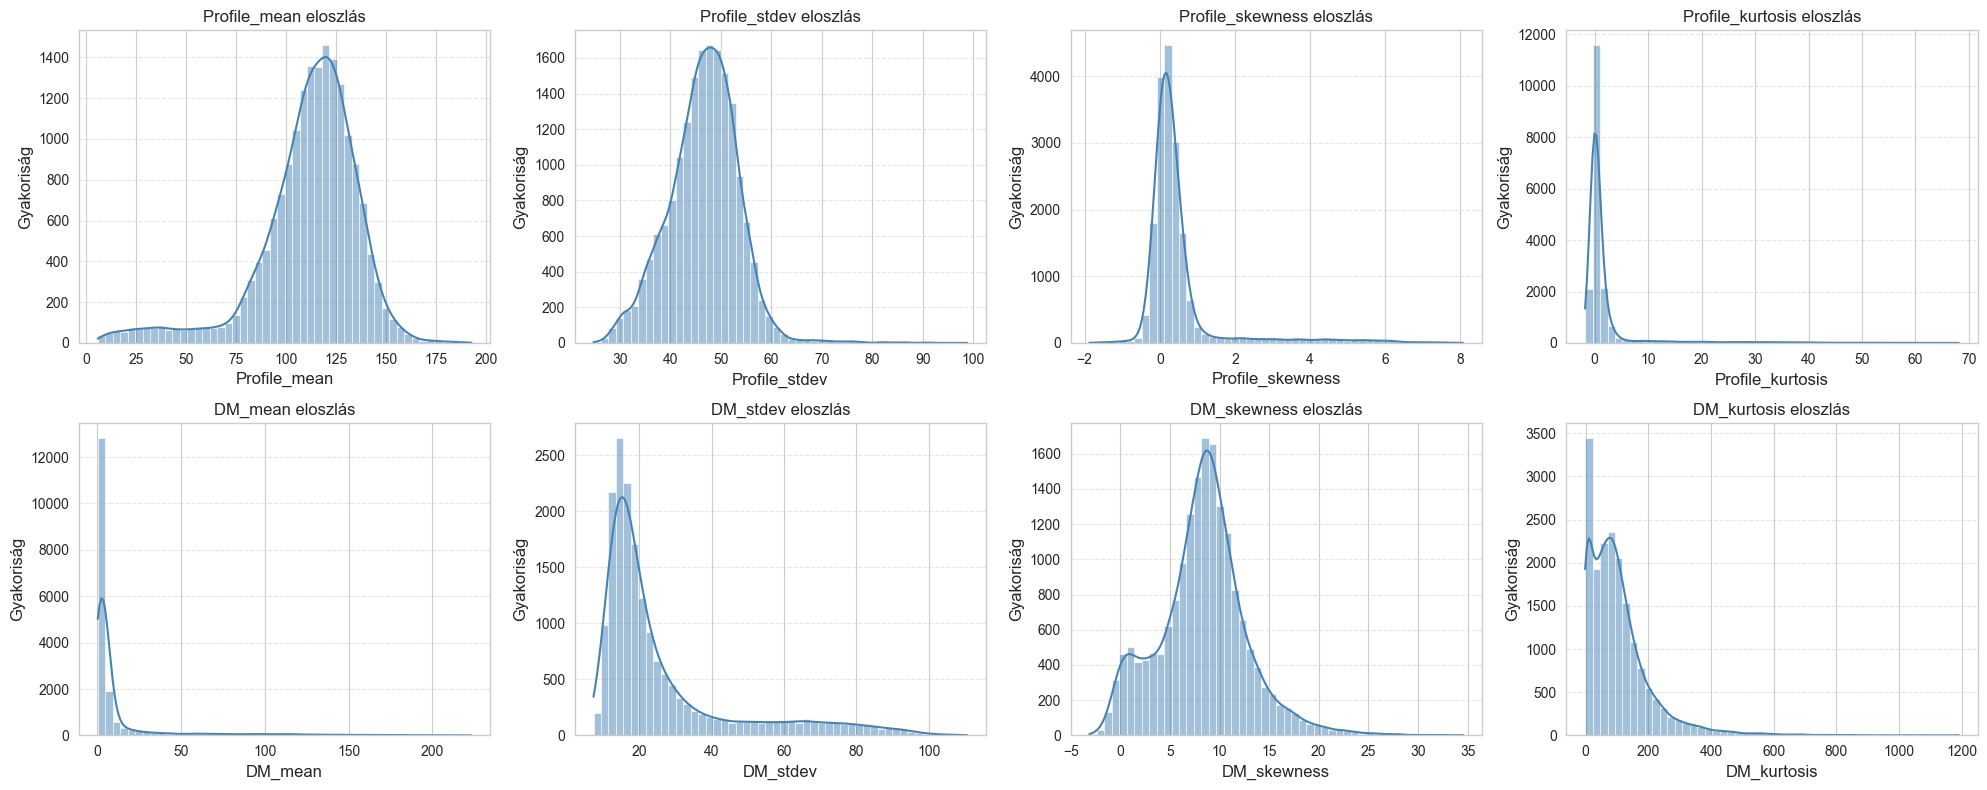

In [15]:
grafikon_eloszlas(X, feature_cimkek)

Itt a Profile_kurtosis kevésbé, de a DM_mean már sokkal jobban el van tolódva az ideálistól. Az igazi problémát szerintem a DM_kurtosis jelenti, mert el is van tolódva, két csúcsa is van.

A következőkben azt próbáltam vizsgálni hogy az egyes adatcsoportokon belül (Profile és DM) vannak-e olyan feature párok amelyek egyes tartományban jól elkülönthetően meghatározzák a kategóriát. Persze ezt csak azért tudom megtenni, mert eleve ismertek a cimkék. Ha nem tudnám színezni akkor azt nézném, hogy van-e valahol lineáris összefüggés.

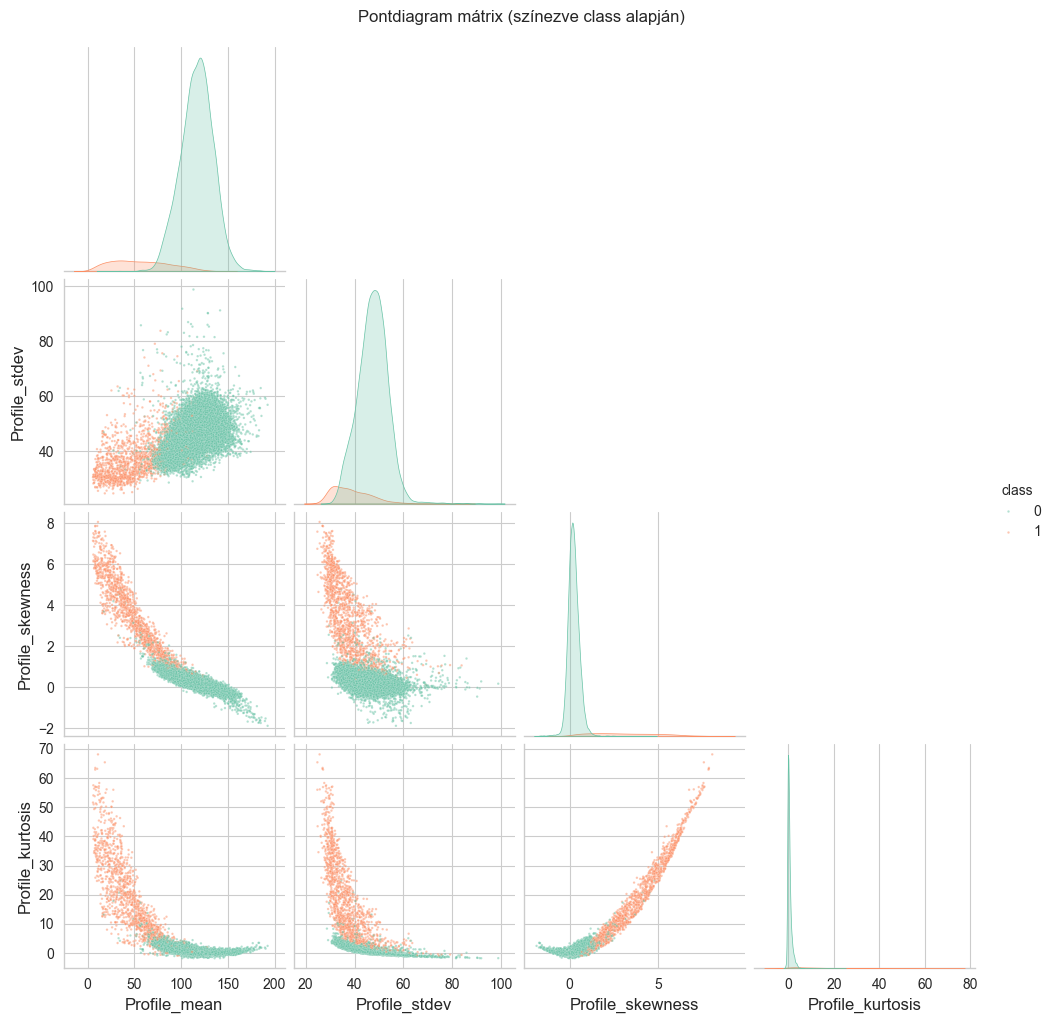

In [16]:
profile_cimkek = [c for c in feature_cimkek if c.startswith('Profile')]
sns.pairplot(pd.concat([X[profile_cimkek], y], axis=1), hue='class', diag_kind='kde', corner=True, palette='Set2', plot_kws={'s': 3, 'alpha': 0.5})
plt.suptitle("Pontdiagram mátrix (színezve class alapján)", y=1.02)
plt.show()

Itt nagyon szépen elkülönülek szinte minden ábrán az egyes csoportok, ebből egyelőre csak annyit tudtam leszűrni, hogy valószűleg a dimenzió csökkentés nem lehetetlen vállalkozás erre az adathalmazra és hogy nagyon egyértelmű lineáris összefüggést nem látok.

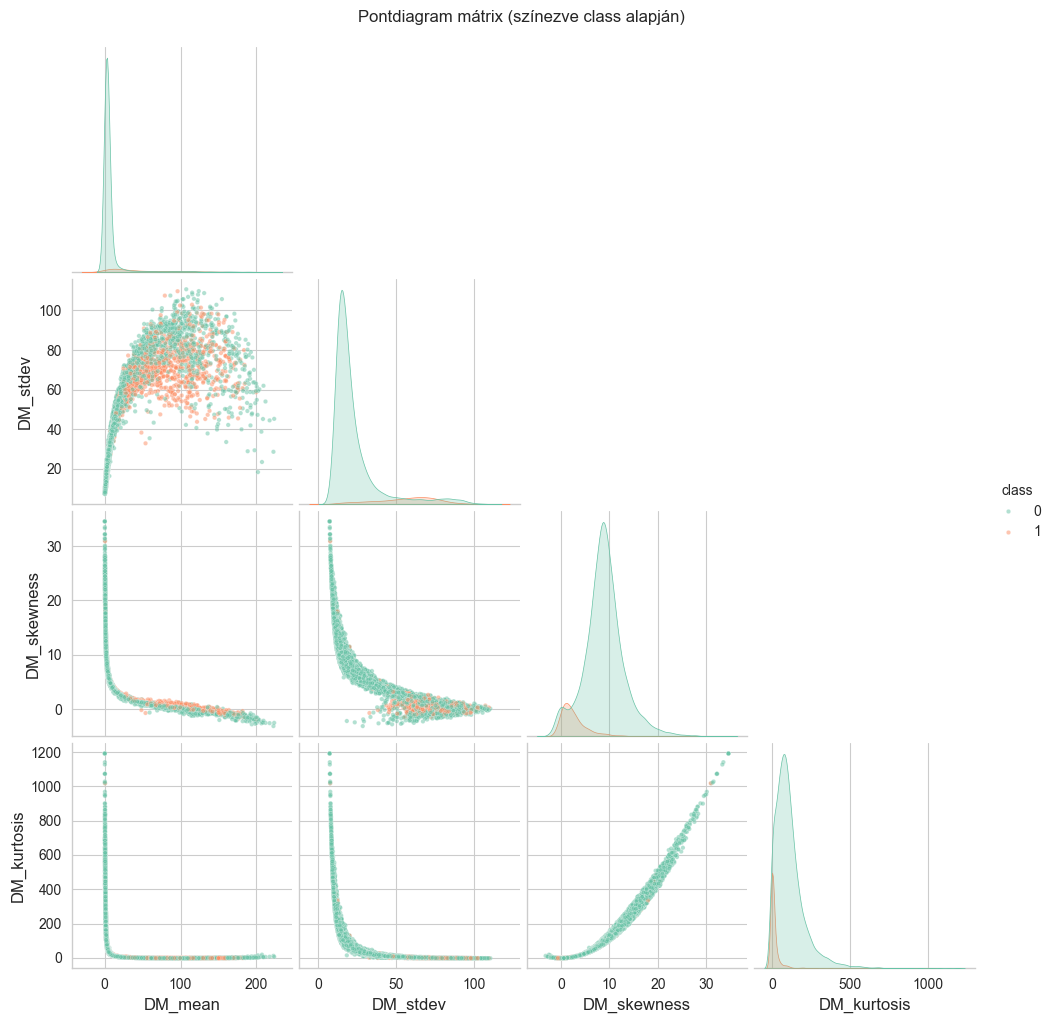

In [17]:
dm_cimkek = [c for c in feature_cimkek if c.startswith('DM')]
sns.pairplot(pd.concat([X[dm_cimkek], y], axis=1), hue='class', diag_kind='kde', corner=True, palette='Set2', plot_kws={'s': 10, 'alpha': 0.5})
plt.suptitle("Pontdiagram mátrix (színezve class alapján)", y=1.02)
plt.show()

Ezekből én sokkal kevésbé tudok hasznos információt leszűrni azon kívül, hogy gyakorlatilag a DM adatok teljes skáláján helyezkednek el elemek mindkét osztályból és hogy nincs lineáris összefüggés az egyes adatpárok közt.

Megjegyzés: sokféle képpen próbáltam még összehasonlítani az adatokat, ami esetleg segít értelmezni a köztük lévő összefüggéseket, de ezek nem sokat segítettek az én megértésemen, ezért végül eltávolítottam őket. A fenti kéttőt azért hagytam meg, mert az adatok leírása alapján is egyértelműnek tűnt, de szerintem a fenti ábrák csak megerősítik, hogy a Profile és a DM adatok külön "életet" élnek.

## Adat tisztítás

Az alábbi átalakítással csak egyetlen y=1 értéket dobok el, de ezekre a rekordok nagyon szélsőséges értékeket tartalmaznak.

In [18]:
megtartott_indexek = X[X["DM_kurtosis"] <= 500].index
X = X.iloc[megtartott_indexek, :]
X.reset_index(drop=True, inplace=True)
y = y.iloc[megtartott_indexek, :]
y.reset_index(drop=True, inplace=True)

Ez az átalakítás szintén egy y=1 adat elvesztésével jár, de a későbbi vizsgálatok során úgy döntöttem ezeket eltávolítom.

In [19]:
megtartott_indexek = X[X["Profile_stdev"] <= 80].index
X = X.iloc[megtartott_indexek, :]
X.reset_index(drop=True, inplace=True)
y = y.iloc[megtartott_indexek, :]
y.reset_index(drop=True, inplace=True)

In [20]:
megtartott_indexek = X[X["DM_mean"] < 100].index
X = X.iloc[megtartott_indexek, :]
X.reset_index(drop=True, inplace=True)
y = y.iloc[megtartott_indexek, :]
y.reset_index(drop=True, inplace=True)

Megjegyzés: próbálkoztam más oszlopok adatának tisztításával is, vagy például az alsó és a felső 1% eltávoltásával, de csak a jelenleginél rosszabb eredményeket kaptam a későbbi műveletek során.

## Adat átalakítás

A DM_kurtosis adatai nagyon ferdék, ezért ezen egy log transzformációt végzek.

In [21]:
X.loc[:,'DM_kurtosis'] = X['DM_kurtosis'] - X['DM_kurtosis'].min() + 1
X.loc[:,'DM_kurtosis'] = np.log(X['DM_kurtosis'])

In [22]:
X.loc[:,'Profile_kurtosis'] = X['Profile_kurtosis'] - X['Profile_kurtosis'].min() + 1
X.loc[:,'Profile_kurtosis'] = np.log(X['Profile_kurtosis'])

In [23]:
X.loc[:,'DM_stdev'] = np.log1p(X['DM_stdev'])

In [24]:
X.loc[:,'DM_mean'] = np.log1p(X['DM_mean'])

Megjegyzés: próbáltam más oszlopokon is transzformációkat végezni, de csak (számomra) kevésbé értelmezhető adatokat sikerült vele elérnem. Például a DM_mean-t nagyon szerettem volna valamely módon átalakítani, de az eredménye minden esetben kevésbé sikeres dimenziócsökkentés lett.

In [25]:
X.describe()

Profile_mean  Profile_stdev  Profile_skewness  Profile_kurtosis  \
count  17030.000000   17030.000000      17030.000000      17030.000000   
mean     111.942852      46.452569          0.428543          1.133321   
std       23.633257       6.494817          0.931746          0.534453   
min        7.843750      24.772042         -1.876011          0.000000   
25%      101.564453      42.407746          0.028533          0.839850   
50%      115.210938      46.895360          0.221047          0.991329   
75%      127.015625      50.880358          0.460341          1.220990   
max      192.617188      78.619808          8.069522          4.257076   

            DM_mean      DM_stdev   DM_skewness   DM_kurtosis  
count  17030.000000  17030.000000  17030.000000  17030.000000  
mean       1.594260      3.094234      8.461510      4.182178  
std        0.866102      0.502541      3.896537      1.210834  
min        0.418754      2.329002     -0.731596      0.000000  
25%        1.071778      2.735797      6.168177      3.769259  
50%        1.322425      2.953979      8.528819      4.480499  
75%        1.767642      3.319615     10.710838      4.959769  
max        4.614533      4.706420     21.788808      6.219134

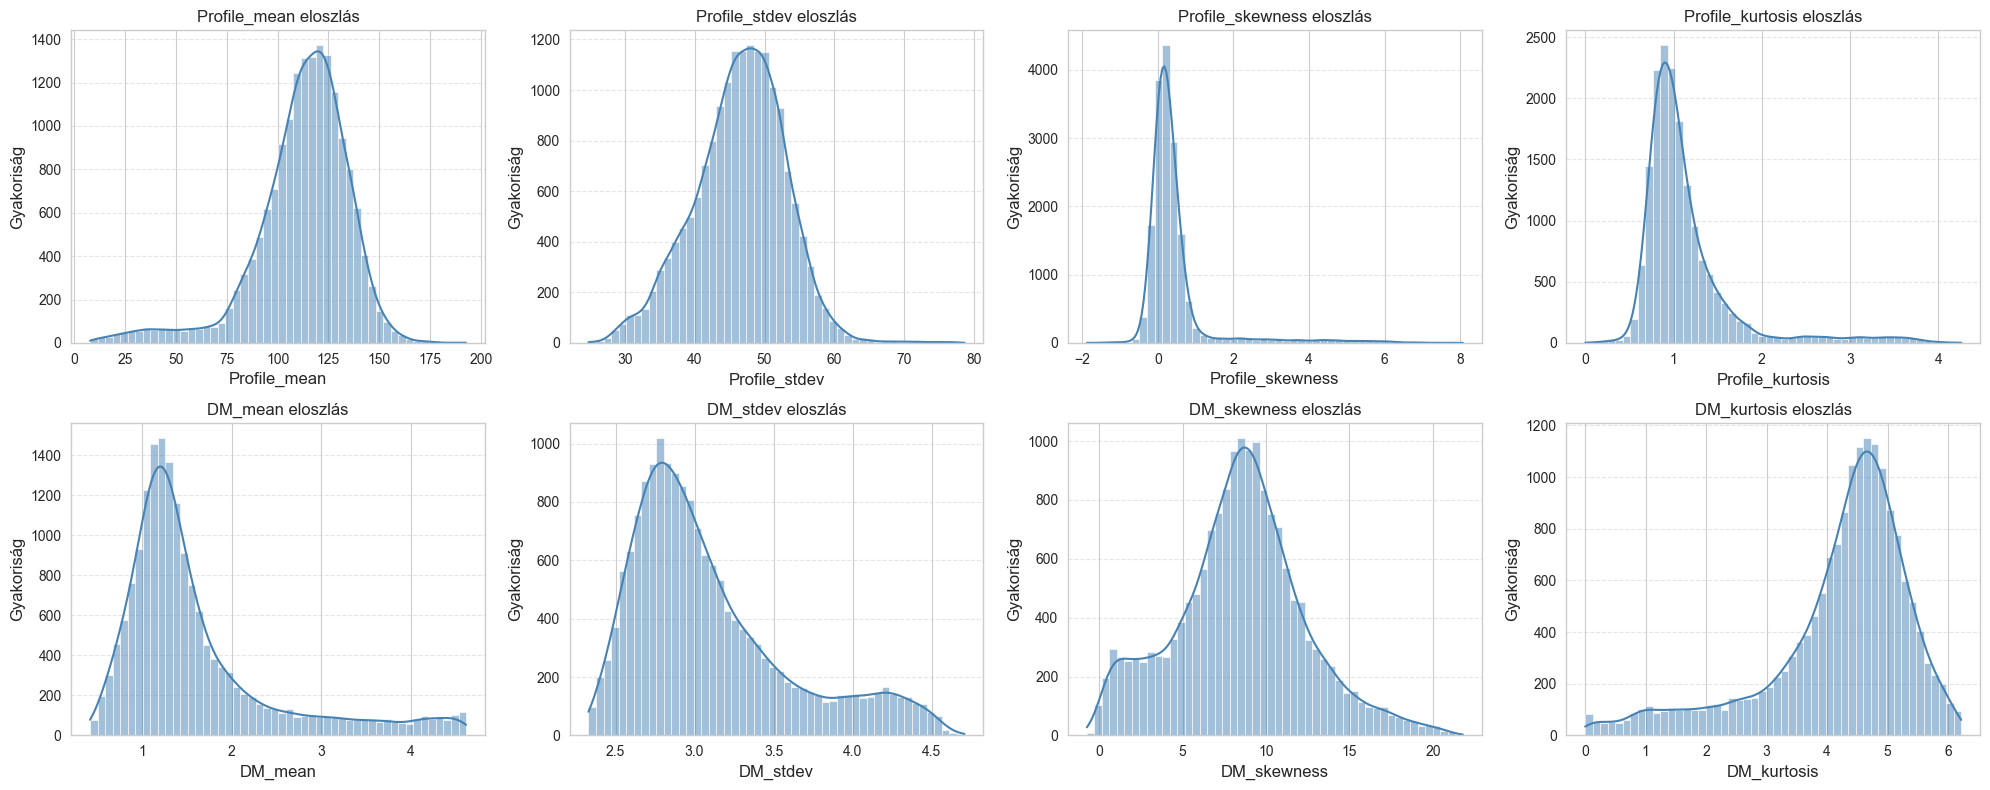

In [26]:
grafikon_eloszlas(X, feature_cimkek)

In [27]:
X_std = pd.DataFrame(StandardScaler().fit_transform(X), columns=feature_cimkek)

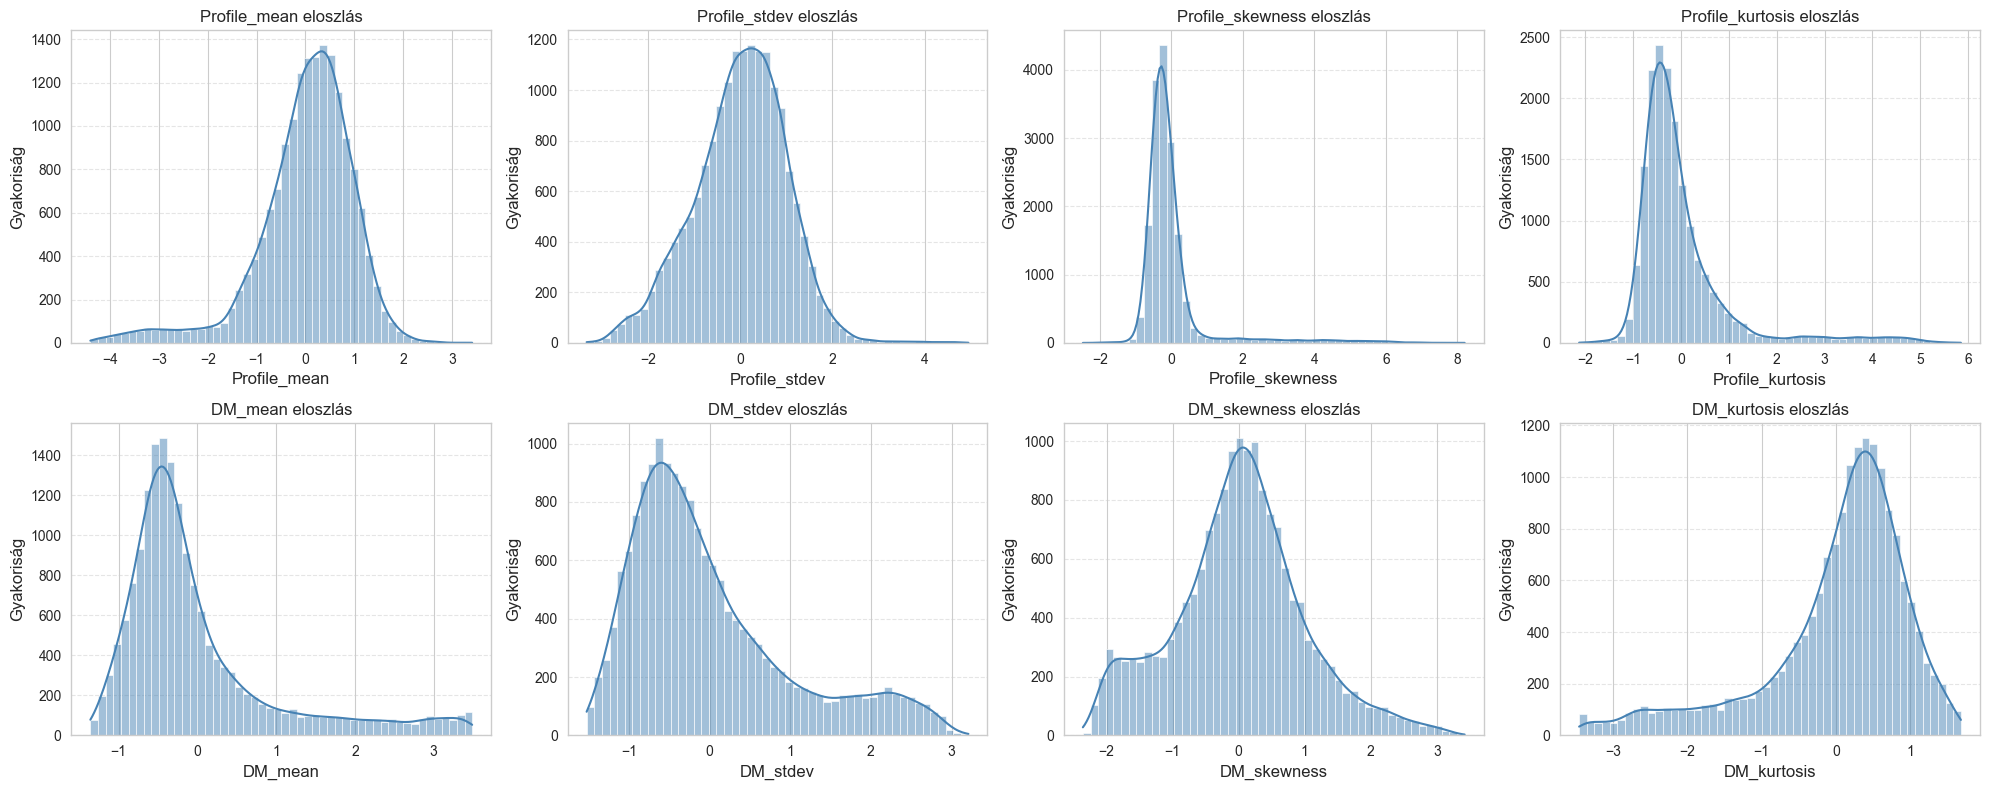

In [28]:
grafikon_eloszlas(X_std, feature_cimkek)

# Factor Analyzer

## Két faktor

In [29]:
fa = FactorAnalyzer(n_factors=2, rotation=None)
fa_scores = fa.fit_transform(X_std)

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [30]:
fa_df = pd.DataFrame(fa.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa.n_factors)], index=feature_cimkek)
fa_df = pd.concat([fa_df, 
                   pd.DataFrame(fa.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df

faktor 1  faktor 2  Kommunalitás  Specifitás
Profile_mean     -0.617038 -0.595492      0.735347    0.264653
Profile_stdev    -0.379930 -0.588098      0.490206    0.509794
Profile_skewness  0.747922  0.538865      0.849763    0.150237
Profile_kurtosis  0.742540  0.679807      1.013503   -0.013503
DM_mean           0.906144 -0.377529      0.963625    0.036375
DM_stdev          0.877751 -0.438716      0.962919    0.037081
DM_skewness      -0.804213  0.455631      0.854358    0.145642
DM_kurtosis      -0.893535  0.453354      1.003935   -0.003935

A Kommunalitás nem tudom, hogyan lehet 1 feletti, gondolom ez vagy számítási hiba, vagy esetleg nem megfelelő skálázás/outlierek. Azonban itt bármelyik skálázást is használtam, hasonlóan furcsa eredmény jött ki.
Érdekes még a Profile_stdev is, amit a két faktor csak nagyon alacsony mértékben magyaráz.

In [31]:
fa_6 = FactorAnalyzer(n_factors=6, rotation=None)
fa_scores_6 = fa_6.fit_transform(X_std)
fa_df_6 = pd.DataFrame(fa_6.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_6.n_factors)], index=feature_cimkek)
fa_df_6 = pd.concat([fa_df_6, 
                   pd.DataFrame(fa_6.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_6.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df_6

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


faktor 1  faktor 2  faktor 3  faktor 4  faktor 5  faktor 6  \
Profile_mean     -0.633637 -0.593280 -0.230991  0.099915  0.179425  0.019396   
Profile_stdev    -0.419531 -0.684042  0.512057 -0.006176  0.040500  0.012471   
Profile_skewness  0.767870  0.533162  0.306700  0.006545  0.095147  0.013090   
Profile_kurtosis  0.742828  0.645134 -0.043968  0.051238  0.114099  0.023000   
DM_mean           0.901422 -0.392061  0.021463  0.138134 -0.000420 -0.096812   
DM_stdev          0.872756 -0.450956 -0.036475  0.082937 -0.065422  0.132166   
DM_skewness      -0.818022  0.488152  0.105693  0.268596 -0.065056  0.004001   
DM_kurtosis      -0.882423  0.459209  0.040161 -0.045839  0.025925  0.039009   

                  Kommunalitás  Specifitás  
Profile_mean          0.849386    0.150614  
Profile_stdev         0.907955    0.092045  
Profile_skewness      0.977218    0.022782  
Profile_kurtosis      0.986097    0.013903  
DM_mean               0.995188    0.004812  
DM_stdev              0.995021    0.004979  
DM_skewness           0.995017    0.004983  
DM_kurtosis           0.995451    0.004549

Ebből én azt látom, hogy a 6 faktor az mindegyik tulajdonságot képes nagyon magas mértékben magyarázni, de ilyen jellegű összefüggő adatoknál ilyen kis mértékű dimenziócsökkentés mellett érthető jelenség. Viszont itt nincsenek 1 feletti Kommunalitás adatok, tehát valószínűleg a std skálázás megfelelő volt az 2 faktornál is, csak épp a 2 faktor kevés az adatokhoz.

### Varimax forgatás

In [32]:
fa_vm = FactorAnalyzer(n_factors=2, rotation='varimax')
fa_scores_vm = fa_vm.fit_transform(X_std)

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
fa_df = pd.DataFrame(fa_vm.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_vm.n_factors)], index=feature_cimkek)
fa_df = pd.concat([fa_df, 
                   pd.DataFrame(fa_vm.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_vm.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df

faktor 1  faktor 2  Kommunalitás  Specifitás
Profile_mean     -0.154279 -0.843531      0.735347    0.264653
Profile_stdev     0.034075 -0.699317      0.490206    0.509794
Profile_skewness  0.293636  0.873808      0.849763    0.150237
Profile_kurtosis  0.207110  0.985194      1.013503   -0.013503
DM_mean           0.956348  0.221410      0.963625    0.036375
DM_stdev          0.968943  0.155142      0.962919    0.037081
DM_skewness      -0.919048 -0.098534      0.854358    0.145642
DM_kurtosis      -0.990300 -0.152449      1.003935   -0.003935

Ezek pontosan ugyan azok a problémák, mint forgatás nélkül, tehát a forgatás ezen nem segített ezek értelmezésében. Viszont az értelmezést jelentősen segíti, mert az látszik belőle, hogy az első faktor a DM adatcsoportra koncentrál a második faktor pedig a Profile adatokra.

### Árázolás

In [34]:
X_fa = pd.DataFrame(data = fa_scores, columns = ['Faktor 1', 'Faktor 2'])
X_fa_vm = pd.DataFrame(data = fa_scores_vm, columns = ['Faktor 1 (varimax)', 'Faktor 2 (varimax)'])
X_2dim_fa = pd.concat([X_fa, X_fa_vm, y], axis = 1)
X_2dim_fa.head()

Faktor 1  Faktor 2  Faktor 1 (varimax)  Faktor 2 (varimax)  class
0 -0.564936 -0.739558           -0.027969           -0.930223      0
1 -0.448217 -0.070384           -0.323177           -0.318448      0
2  0.069687  0.043413            0.031320            0.075895      0
3 -0.193426 -0.839785            0.332325           -0.795118      0
4 -0.707872  1.042215           -1.182674            0.434255      0

In [35]:
fa_data = { "data" : X_2dim_fa, "x_label" : "Faktor 1", "y_label" : "Faktor 2",
        "figs" : [
            {"id": 0, "method": "Faktor Analyzer", "msg": "eredeti", "x": "Faktor 1", "y": "Faktor 2"},
            {"id": 1, "method": "Faktor Analyzer", "msg": "varimax", "x": "Faktor 1 (varimax)", "y": "Faktor 2 (varimax)"}
        ]}

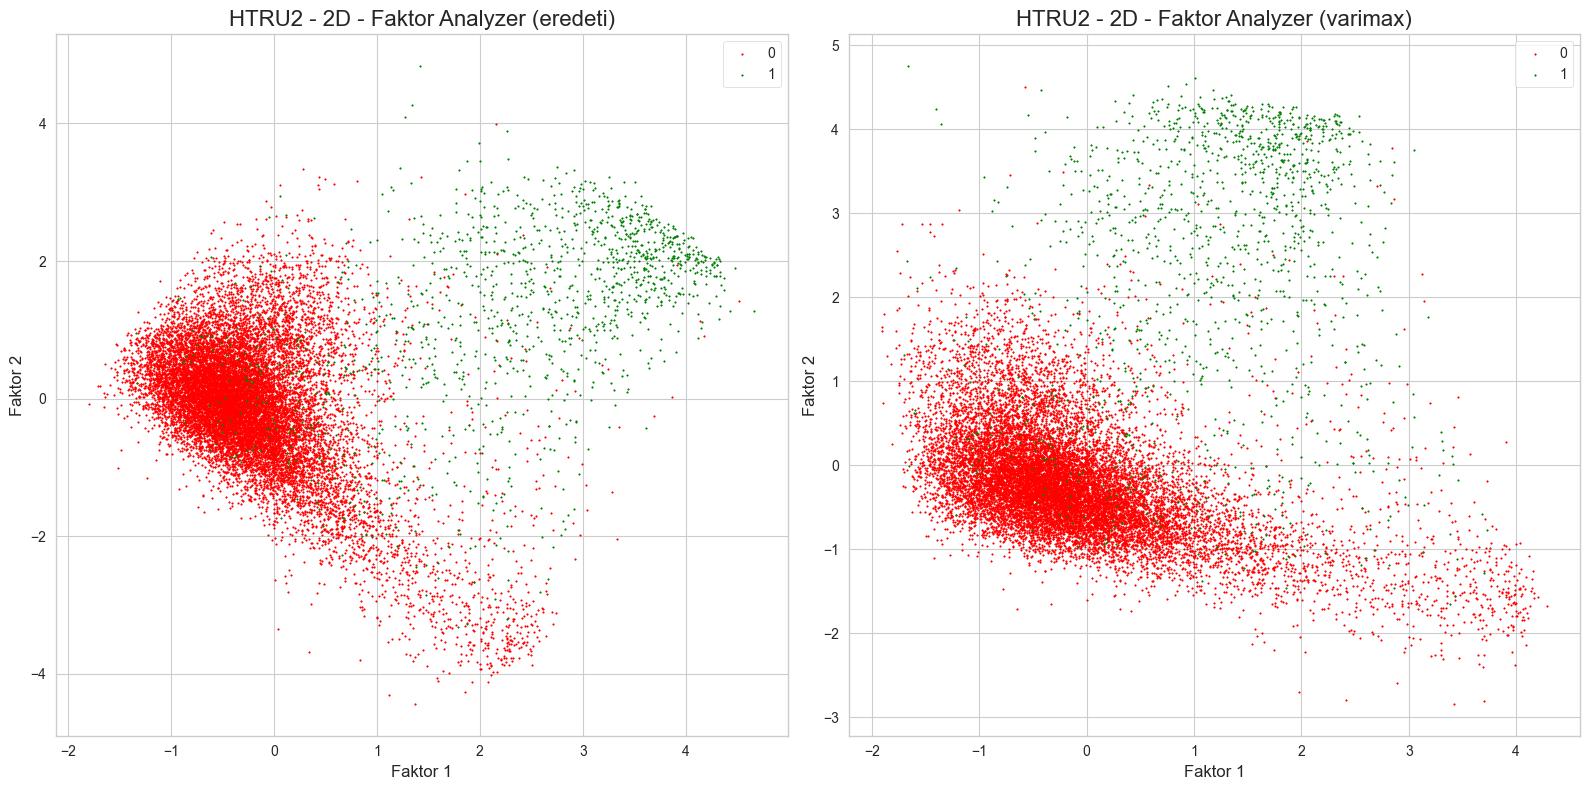

In [36]:
grafikon_scatter_2d(fa_data)

A hibák ellenére azért itt kirajzolódik két egészen jól elkülönülő klaszter. A pirosak közepén ugyan láthatóak a zöld klaszter tagjai is, lehet, hogy ezen egy harmadik faktor segítene.

## Három faktor

In [37]:
fa_3 = FactorAnalyzer(n_factors=3, rotation=None)
fa_scores_3 = fa_3.fit_transform(X_std)
fa_df_3 = pd.DataFrame(fa_3.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_3.n_factors)], index=feature_cimkek)
fa_df_3 = pd.concat([fa_df_3, 
                   pd.DataFrame(fa_3.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_3.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df_3

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


faktor 1  faktor 2  faktor 3  Kommunalitás  Specifitás
Profile_mean     -0.625319  0.561962 -0.206917      0.749640    0.250360
Profile_stdev    -0.432888  0.714652  0.545238      0.995403    0.004597
Profile_skewness  0.776059 -0.528095  0.342288      0.998313    0.001687
Profile_kurtosis  0.743179 -0.630571  0.003843      0.949950    0.050050
DM_mean           0.896765  0.397294  0.004524      0.962050    0.037950
DM_stdev          0.868023  0.454805 -0.050515      0.962864    0.037136
DM_skewness      -0.795920 -0.469224  0.089922      0.861745    0.138255
DM_kurtosis      -0.883576 -0.469348  0.057145      1.004260   -0.004260

Itt a DM_kurtosis 1 feletti értéke mint probléma továbbra is fenáll, de az viszont jól látszik, hogy 3 faktor már képes a Profile_stdev tulajdonság varianciájának nagyarányú magyarázatára.

### Oblimin forgatás

In [38]:
fa_3_om = FactorAnalyzer(n_factors=3, rotation='oblimin')
fa_scores_3_om = fa_3_om.fit_transform(X_std)
fa_df_3_om = pd.DataFrame(fa_3_om.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_3_om.n_factors)], index=feature_cimkek)
fa_df_3_om = pd.concat([fa_df_3_om, 
                   pd.DataFrame(fa_3_om.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_3_om.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df_3_om

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


faktor 1  faktor 2  faktor 3  Kommunalitás  Specifitás
Profile_mean      0.048159 -0.845049  0.062315      0.720310    0.279690
Profile_stdev     0.002925 -0.020709  0.985750      0.972141    0.027859
Profile_skewness  0.032000  1.035877  0.090542      1.082264   -0.082264
Profile_kurtosis  0.065978  0.708229 -0.345628      0.625399    0.374601
DM_mean           0.938146  0.109157  0.039525      0.893596    0.106404
DM_stdev          0.981816 -0.001245  0.001040      0.963966    0.036034
DM_skewness      -0.956164  0.083740  0.030029      0.922164    0.077836
DM_kurtosis      -1.006408  0.011816  0.003190      1.013006   -0.013006

A Kommunalitás értékek ugyan csökkentek, de az egyes faktorok számomra így jobban értelmezhetőek: az első faktor gyakorlatilag kizárólag a DM adatok lineáris kombinációja, itt a Profile súlyok nagyon alacsonyak. A második faktorban a Profile adatok skewness, kurtosis, mean adatok a meghatározóak. A harmadik faktor pedig profil szórását veszi nagy súllyal figyelembe, így nyilván megoldódott az a probléma ami a két faktornál volt, hogy a Profile_stdev Kommunalitása alacsony volt.

### Ábrázolás

In [39]:
X_fa_3 = pd.DataFrame(data = fa_scores_3, columns = ['Faktor 1', 'Faktor 2', 'Faktor 3'])
X_fa_3_om = pd.DataFrame(data = fa_scores_3_om, columns = ['Faktor 1 (oblimin)', 'Faktor 2 (oblimin)', 'Faktor 3 (oblimin)'])
X_3dim_fa = pd.concat([X_fa_3, X_fa_3_om, y], axis = 1)
fa_3_data = { "data" : X_3dim_fa, "x_label" : "Faktor 1", "y_label" : "Faktor 2", "z_label" : "Faktor 3",
        "figs" : [
            {"id": 0, "method": "Faktor Analyzer", "msg": "eredeti", "x": "Faktor 1", "y": "Faktor 2", "z": "Faktor 3"},
            {"id": 1, "method": "Faktor Analyzer", "msg": "oblimin", "x": "Faktor 1 (oblimin)", "y": "Faktor 2 (oblimin)", "z": "Faktor 3 (oblimin)"}
        ]}

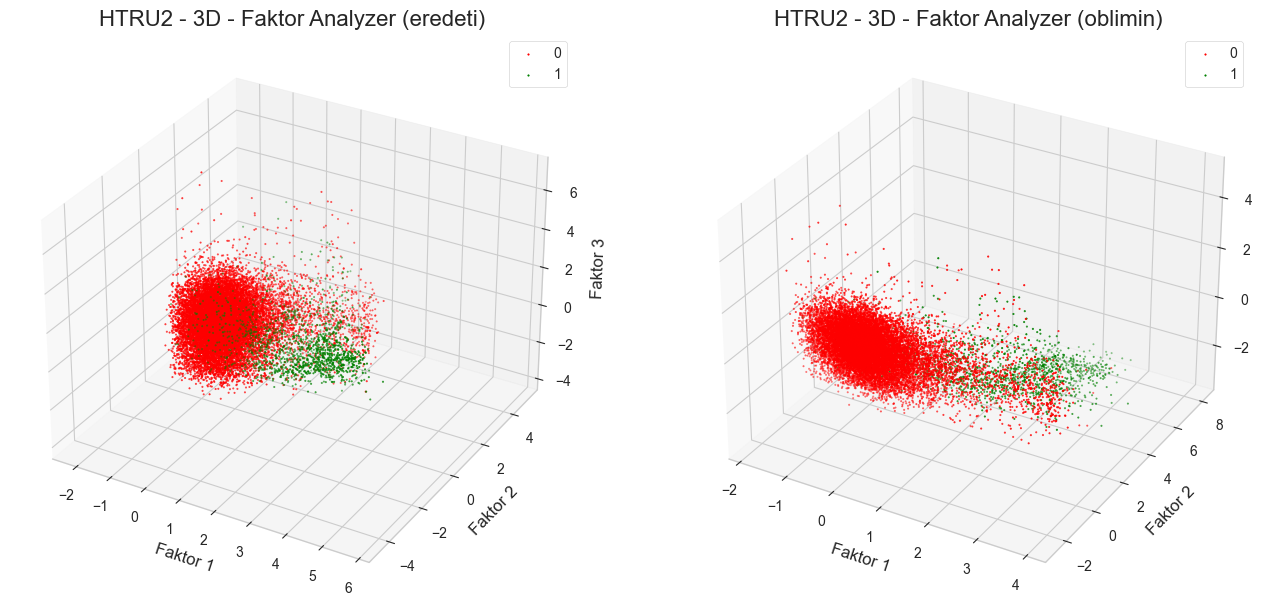

In [40]:
grafikon_scatter_3d(fa_3_data)

A forgatás itt nem sokat segít az ábra értelmezésében, a piros klaszter formája sokkal jobban megfigyelhető a forgatás nélkül (legalábbis ebből a perspektívából).

# PCA

## Standardizálás

Mivel a standard scalerrel skálázott adatokon végzett faktor analízis során számomra nem minden esetben érthető eredmény született, ezért más féle módszereket is kipróbáltam a skálázásra. Ezek különböző módon kezelik az outlireket, ezért várhatóan más eredményt hoznak a PCA során.

In [41]:
X_rbst = pd.DataFrame(RobustScaler(unit_variance = True).fit_transform(X), columns=feature_cimkek)

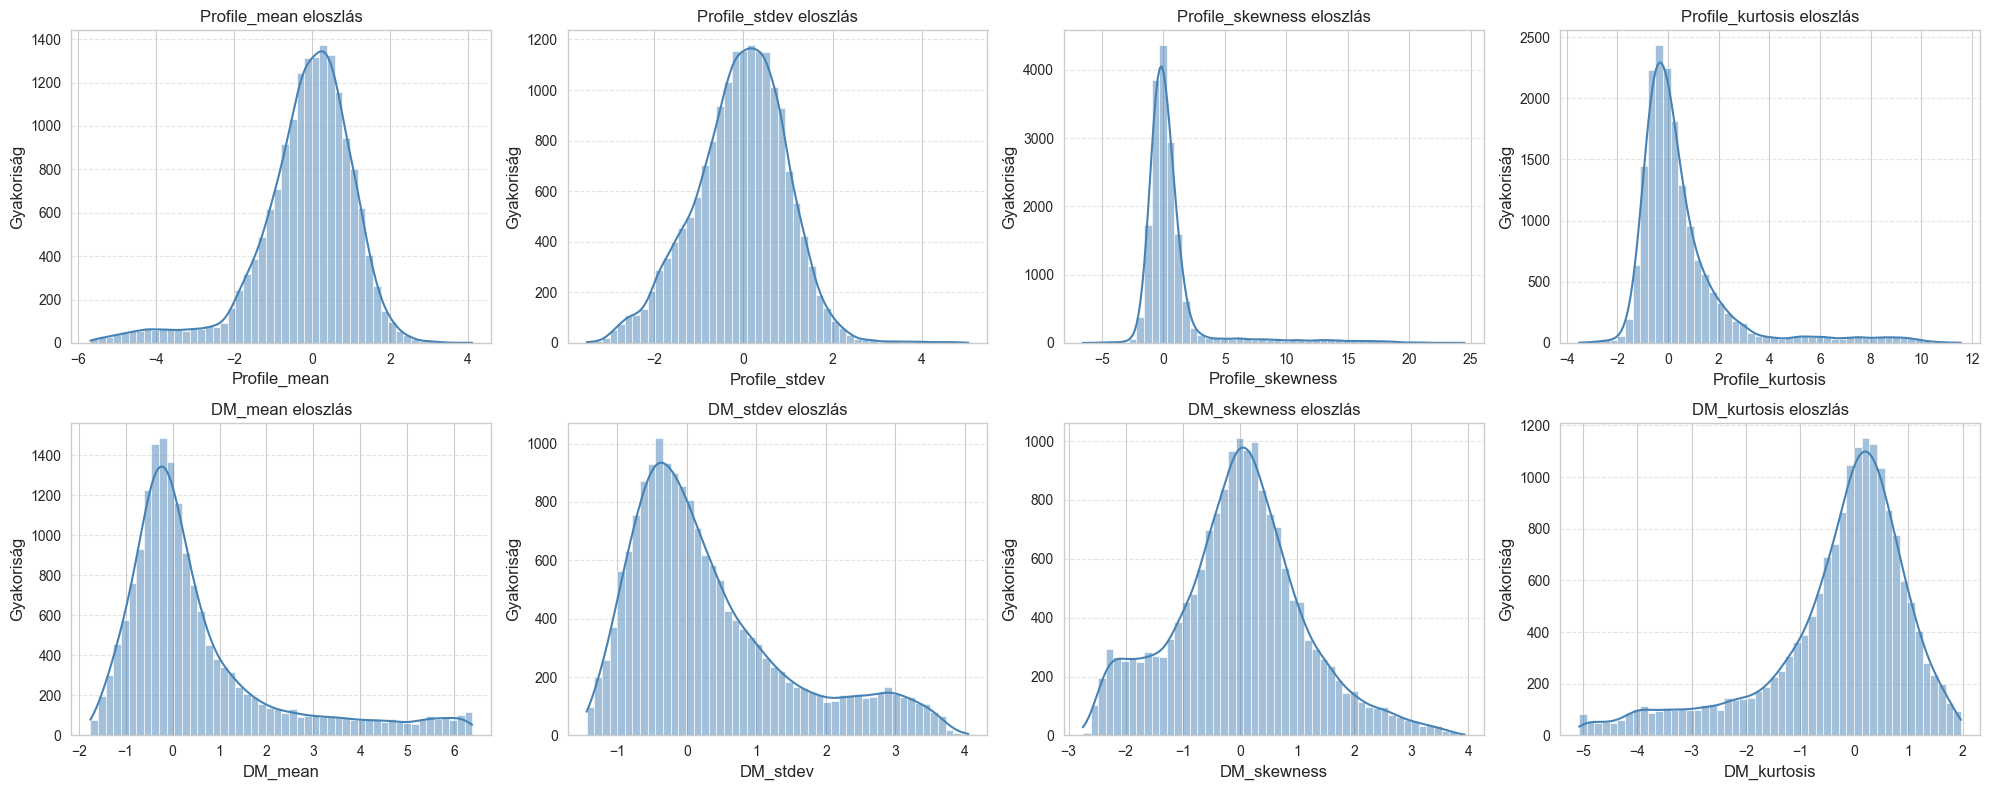

In [42]:
grafikon_eloszlas(X_rbst, feature_cimkek)

## Két komponens

Első körben azt vizsgáltam meg, hogy a PCA segítségével hány főkomponensre lenne szükség, ha a varianciát legalább 95%-ban szeretném ha magyaráznák.

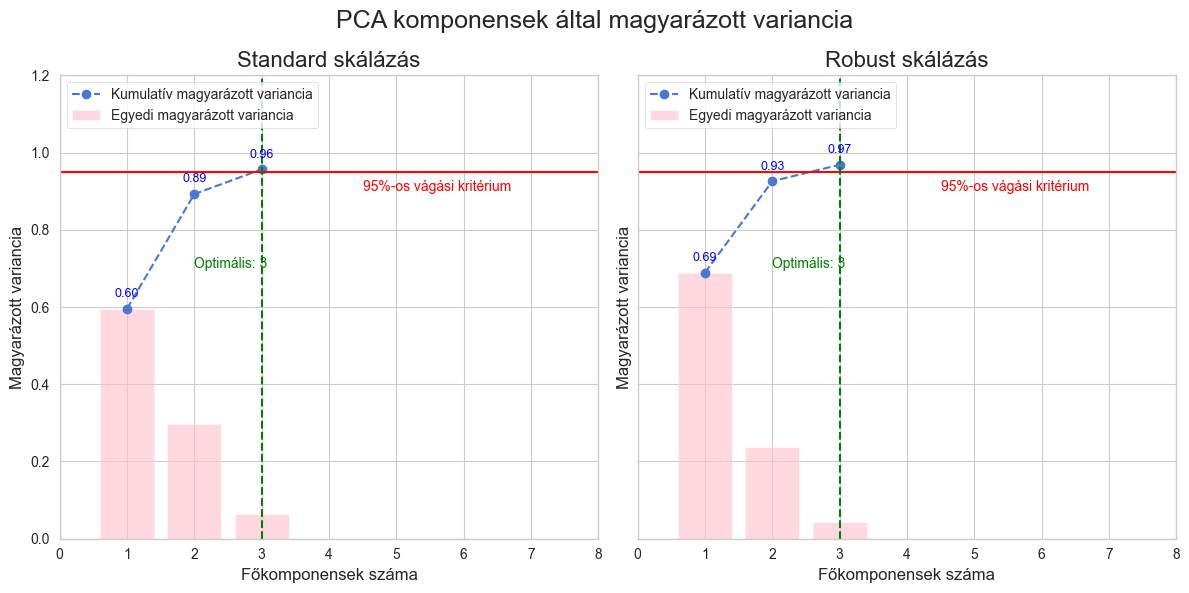

In [43]:
pca_results = {}
methods = {"standard": X_std, "robust": X_rbst}

for tipus, adat in methods.items():
    pca = PCA(n_components = 0.95, svd_solver = 'full')
    pca.fit(adat)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    optimal_num_components = len(cumulative_explained_variance[cumulative_explained_variance < 0.95]) + 1

    pca_results[tipus] = {
        "explained": explained_variance_ratio,
        "cumulative": cumulative_explained_variance,
        "optimal": optimal_num_components
    }

fig, axes = plt.subplots(1, len(methods), figsize=(len(methods) * 6, 6), sharey=True)
plt.suptitle("PCA komponensek által magyarázott variancia", fontsize=18)

for ax, (tipus, results) in zip(axes, pca_results.items()):
    ax.bar(range(1, len(results["explained"]) + 1), results["explained"], alpha=0.6, color='pink', label='Egyedi magyarázott variancia')
    ax.plot(range(1, len(results["cumulative"]) + 1), results["cumulative"], marker='o', linestyle='--', label='Kumulatív magyarázott variancia')
    ax.set_title(f'{tipus.capitalize()} skálázás', fontsize=16)
    ax.set_xlabel('Főkomponensek száma')
    ax.set_ylabel('Magyarázott variancia')
    ax.axis([0, 8, 0, 1.2])
    ax.axhline(y=0.95, color='r', linestyle='-')
    ax.axvline(x=results["optimal"], color='g', linestyle='--')
    ax.text(4.5, 0.9, '95%-os vágási kritérium', color='red', fontsize=10)
    ax.text(2, 0.7, f'Optimális: {results["optimal"]}', color='green', fontsize=10)
    ax.grid(True)
    ax.legend(loc='upper left')

    for i, value in enumerate(results["cumulative"]):
        ax.text(i + 1, value + 0.03, f"{value:.2f}", ha='center', fontsize=9, color='blue')

plt.tight_layout()
plt.show()


A fentiek alapján a Robust skálázást és a két főkomponenst választottam, ami ugyan csak 93%-ban magyarázza a varianciát, de lehetőséget ad a 2 és 3 főkomponens összehasonlítására.

### Töltősúlyok

In [44]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_rbst)
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

rotator_vm = Rotator(method='varimax')
varimax_loadings = rotator_vm.fit_transform(pca_loadings)

rotator_ob = Rotator(method='oblimin')
oblimin_loadings = rotator_ob.fit_transform(pca_loadings)

pca_df = pd.DataFrame(pca_loadings, columns=[f'PCA PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
varimax_df = pd.DataFrame(varimax_loadings, columns=[f'Varimax PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
oblimin_df = pd.DataFrame(oblimin_loadings, columns=[f'Oblimin PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
combined_df = pd.concat([pca_df, varimax_df, oblimin_df], axis=1)

print("Főkomponensek töltősúlyai:")
combined_df

Főkomponensek töltősúlyai:


PCA PC 1  PCA PC 2  Varimax PC 1  Varimax PC 2  \
Profile_mean     -1.040500  0.405676     -1.099798     -0.194052   
Profile_stdev    -0.579732  0.413745     -0.710312      0.052265   
Profile_skewness  2.790568 -0.669131      2.731952      0.878321   
Profile_kurtosis  1.737439 -0.557095      1.773943      0.426821   
DM_mean           1.148306  1.201485      0.356801      1.623227   
DM_stdev          0.723394  0.880399      0.160597      1.128100   
DM_skewness      -0.636028 -0.888094     -0.081954     -1.089278   
DM_kurtosis      -0.863775 -1.060161     -0.187131     -1.354633   

                  Oblimin PC 1  Oblimin PC 2  
Profile_mean         -1.174353      0.148417  
Profile_stdev        -0.790617      0.285290  
Profile_skewness      2.845404      0.054028  
Profile_kurtosis      1.873591     -0.117984  
DM_mean               0.098507      1.616131  
DM_stdev             -0.027624      1.151402  
DM_skewness           0.107082     -1.135406  
DM_kurtosis           0.039456     -1.384461

Ezek közül szerintem a Oblimin a legjobban értelmezhető: a két főkomponens egyike (PC1) főként a Profile értékekre koncentrál, a másik (PC2) a DM értékekre. A PC1 a Profile értékeket veszi a legnagyobb súlyokkal figyelembe, azokból is elsősorban a skewness és a kurtosis értékeket. A PC2 a DM értékeket veszi nagy súlyokkal figyelembe, elsősorban a mean és kurtosis értékekre koncentrálva (bár ez utóbbit nagy, de negatív súllyal). Mindkét főkomponens egy adatcsoportra koncentrál és a másik adatcsoport értékeit nullához közeli súlyokkal veszi figyelembe. Ez számomra azért a legértelmezhetőbb, mert az adatokat ismerve a Profile és a DM két teljesen egyértelműen különböző tulajdonságát írják le a megfigyelt jelenségnek, csak több statisztikai értékkel, és ezek a főkomponensek ezt fejezik ki számokkal.

### Ábrázolás

In [45]:
varimax_projection = pd.DataFrame(np.dot(X_rbst, varimax_loadings), columns = ['Varimax PC 1', 'Varimax PC 2'])
oblimin_projection = pd.DataFrame(np.dot(X_rbst, oblimin_loadings), columns = ['Oblimin PC 1', 'Oblimin PC 2'])
principal_df = pd.DataFrame(data = principal_components, columns = ['PCA PC 1', 'PCA PC 2'])
X_2dim_pca = pd.concat([principal_df, varimax_projection, oblimin_projection, y], axis = 1)

In [46]:
pca_data = { "data" : X_2dim_pca, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2",
        "figs" : [
            {"id": 0, "method": "PCA", "msg": "eredeti", "x": "PCA PC 1", "y": "PCA PC 2"},
            {"id": 1, "method": "PCA", "msg": "Varimax", "x": "Varimax PC 1", "y": "Varimax PC 2"},
            {"id": 2, "method": "PCA", "msg": "Oblimin", "x": "Oblimin PC 1", "y": "Oblimin PC 2"}
        ]}

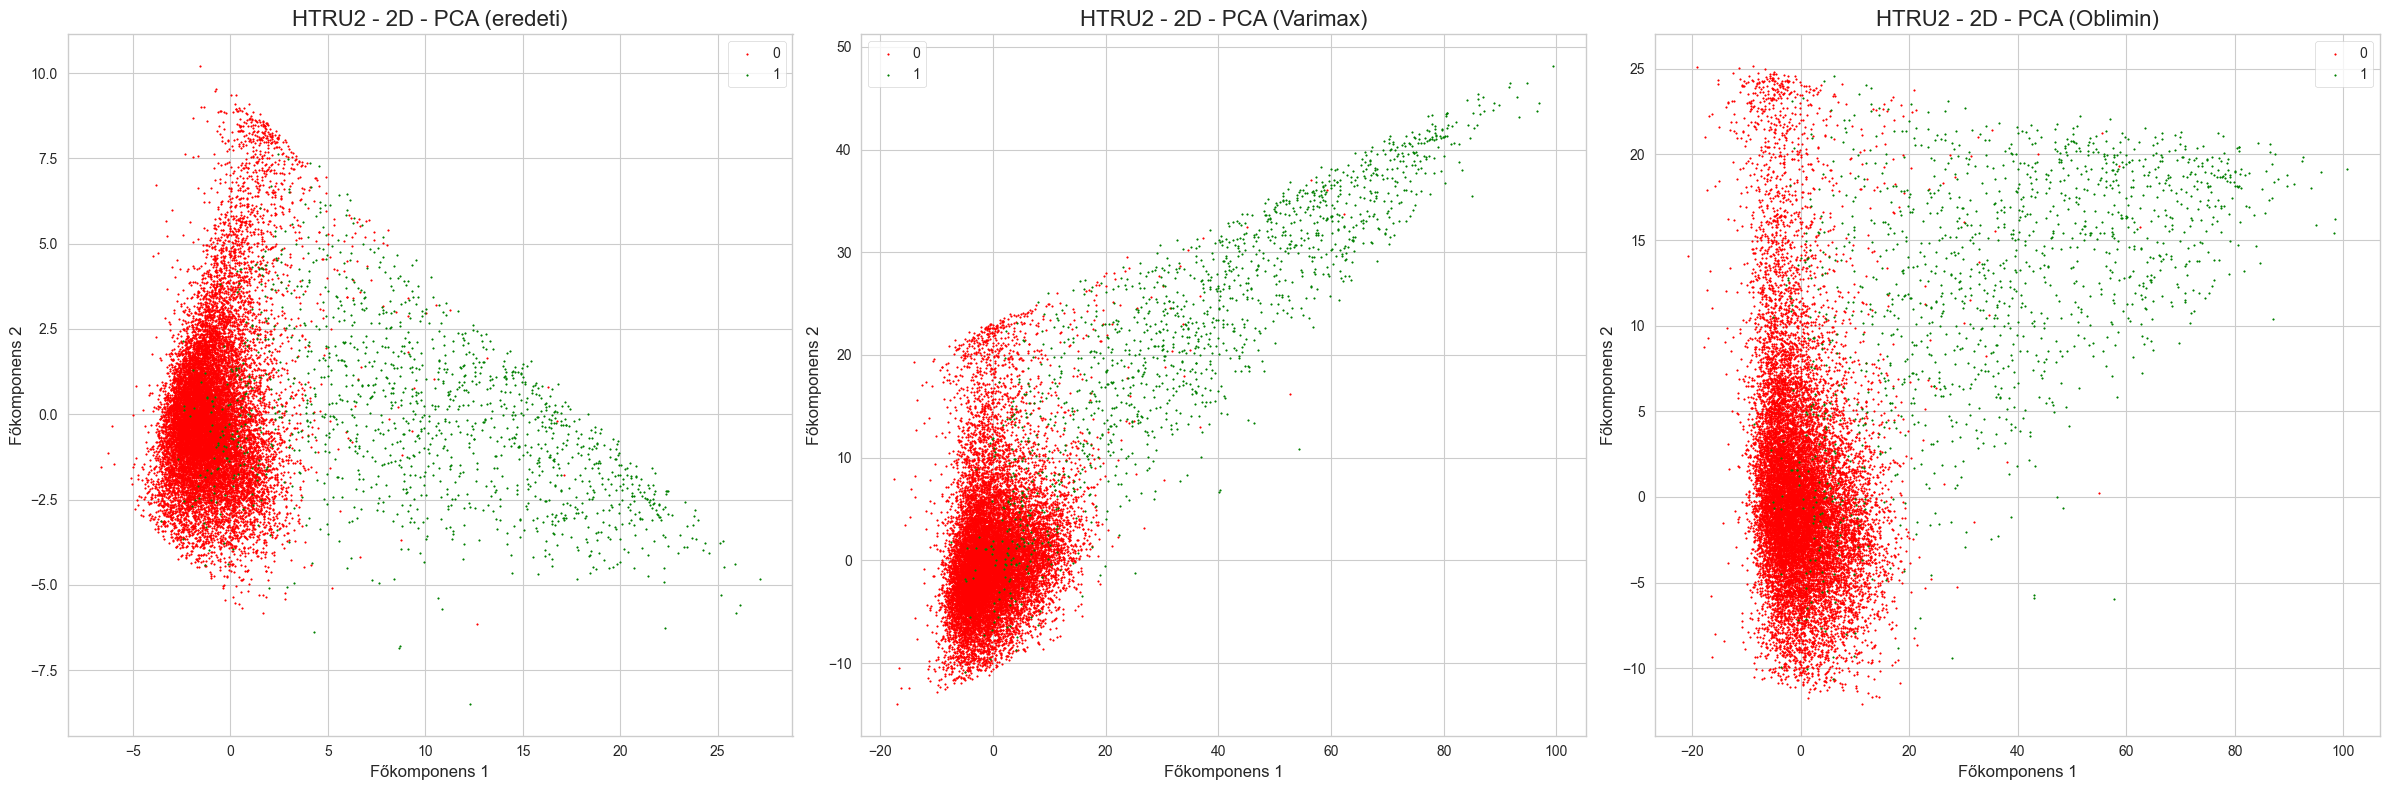

In [47]:
grafikon_scatter_2d(pca_data)

Itt persze megint sokat segít, hogy "szerencsés" módon ismertek a klaszterek cimkéi és ezért tudom színezni az ábrát. Viszont az Oblimin forgatás itt is jól kifejezi azt, amit a pontdiagram mátrixnál is megemlítettem, hogy a DM értékek gyakorlatilag teljes skáláján lehet mindkét klaszterből és ez látszik itt is, hogy bárhol is járok az Y tengelyen, mindkét klaszter értékei előfordulhatnak. Ellenben a X tengelyen amely a Profile adatokra koncentrál, már sokkal jobban elkülöníthető a két kategória.

## Három komponens

### Töltősúlyok

In [48]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_rbst)
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

rotator_vm = Rotator(method='varimax')
varimax_loadings = rotator_vm.fit_transform(pca_loadings)

rotator_ob = Rotator(method='oblimin')
oblimin_loadings = rotator_ob.fit_transform(pca_loadings)

pca_df = pd.DataFrame(pca_loadings, columns=[f'PCA PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
varimax_df = pd.DataFrame(varimax_loadings, columns=[f'Varimax PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
oblimin_df = pd.DataFrame(oblimin_loadings, columns=[f'Oblimin PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
combined_df = pd.concat([pca_df, varimax_df, oblimin_df], axis=1)

print("Főkomponensek töltősúlyai:")
combined_df

Főkomponensek töltősúlyai:


PCA PC 1  PCA PC 2  PCA PC 3  Varimax PC 1  Varimax PC 2  \
Profile_mean     -1.040500  0.405676 -0.077517     -1.077981     -0.151430   
Profile_stdev    -0.579732  0.413745  0.725520     -0.444417      0.020336   
Profile_skewness  2.790568 -0.669131  0.449596      2.779759      0.751586   
Profile_kurtosis  1.737439 -0.557095 -0.432361      1.571061      0.399977   
DM_mean           1.148306  1.201485 -0.007988      0.425164      1.606574   
DM_stdev          0.723394  0.880399 -0.053588      0.197620      1.123037   
DM_skewness      -0.636028 -0.888094  0.094713     -0.108061     -1.090048   
DM_kurtosis      -0.863775 -1.060161  0.064019     -0.231986     -1.348716   

                  Varimax PC 3  Oblimin PC 1  Oblimin PC 2  Oblimin PC 3  
Profile_mean          0.261242     -1.080569      0.125760      0.133905  
Profile_stdev         0.914185      0.122833      0.008203      1.088946  
Profile_skewness     -0.381054      2.913331      0.018936      0.028003  
Profile_kurtosis     -0.942215      1.122426      0.104036     -0.916107  
DM_mean              -0.019819      0.116374      1.614277      0.045695  
DM_stdev             -0.031728     -0.052457      1.162160     -0.009630  
DM_skewness           0.048284      0.165244     -1.156803      0.047459  
DM_kurtosis           0.035986      0.067938     -1.397002      0.009850

Számomra itt is az Oblimin a legjobban értelmezhető. Az első főkomponensben a legnagyobb súlyokat a Profile_skewness, Profile_kurtosis, Profile_mean adják. Ez a komponens a profil eloszlásának aszimmetriáját és csúcsosságát mutatja, a profil átlagértéke ellentétesen befolyásolja. A második főkomponensben a legnagyobb súlyokat a DM adatok csoportja adja. A harmadik főkomponens a Profile_stdev és a Profile_kurtosis ami a Profile értékek szórására koncentrál, ezt a laposság/csúcsosság nagy mértékben negatívan befolyásolja.

### Ábrázolás

In [49]:
oblimin_projection = pd.DataFrame(np.dot(X_rbst, oblimin_loadings), columns = ['Oblimin PC 1', 'Oblimin PC 2', 'Oblimin PC 3'])
principal_df = pd.DataFrame(data = principal_components, columns = ['PCA PC 1', 'PCA PC 2',  'PCA PC 3'])
X_3dim_pca = pd.concat([principal_df, oblimin_projection, y], axis = 1)
X_3dim_pca.head()

PCA PC 1  PCA PC 2  PCA PC 3  Oblimin PC 1  Oblimin PC 2  Oblimin PC 3  \
0 -3.111595  1.335984  0.891036     -7.043325      0.886857      2.968280   
1 -1.547484 -0.899366  2.447676      2.051174     -3.054531      3.005737   
2  0.215222 -0.384617 -1.196926      2.519056      1.496962     -2.293368   
3 -2.441960  1.629942  1.204398     -5.211042      2.299361      3.091013   
4 -0.238966 -3.400337 -0.228663      6.323222     -6.565335     -2.141068   

   class  
0      0  
1      0  
2      0  
3      0  
4      0

In [50]:
pca_data_3d = { "data" : X_3dim_pca, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2", "z_label" : "Főkomponens 3",
        "figs" : [
            {"id": 0, "method": "PCA", "msg": "eredeti", "x": "PCA PC 1", "y": "PCA PC 2", "z": "PCA PC 3"},
            {"id": 1, "method": "PCA", "msg": "Oblimin", "x": "Oblimin PC 1", "y": "Oblimin PC 2", "z": "Oblimin PC 3"}
        ]}

In [51]:
grafikon_scatter_forgathato_3d(pca_data_3d)

# MDS

Itt sajnos kénytelen vagyok az adatoknak csak egy részén dolgozni, mert nagyon sokat fut az MDS a teljes adathalmazon.

In [52]:
sample_indexek = X_rbst.sample(2000, random_state=20190713).index
X_rbst_sample = X_rbst.loc[sample_indexek].reset_index(drop=True)
y_rbst_sample = y.loc[sample_indexek].reset_index(drop=True)

In [53]:
mds_nonmetr = MDS(n_components=2, n_init=15, verbose=1, metric=False, max_iter=100)
X_rbst_mds_nm = mds_nonmetr.fit_transform(X_rbst_sample)

breaking at iteration 1 with stress 0.30163021019121633
breaking at iteration 1 with stress 0.3022663806735184
breaking at iteration 1 with stress 0.3024436360038485
breaking at iteration 1 with stress 0.3022942901588085
breaking at iteration 1 with stress 0.30185299832886237
breaking at iteration 1 with stress 0.3024030133532527
breaking at iteration 1 with stress 0.30229404307982616
breaking at iteration 1 with stress 0.3013937194672851
breaking at iteration 1 with stress 0.30258046731699717
breaking at iteration 1 with stress 0.3026789090000318
breaking at iteration 1 with stress 0.3021262773391593
breaking at iteration 1 with stress 0.3022528383633222
breaking at iteration 1 with stress 0.30223771438047237
breaking at iteration 1 with stress 0.3022728204008518
breaking at iteration 1 with stress 0.3016813927390627


0.3-nal jobb stress értéket nem sikerült elérnem a teljes adathalmazon sem.

In [54]:
mds_metr = MDS(n_components=2, n_init=5, verbose=1, metric=True, max_iter=1000)
X_rbst_mds_m = mds_metr.fit_transform(X_rbst_sample)

breaking at iteration 265 with stress 354361.54702285724
breaking at iteration 306 with stress 354441.90934479854
breaking at iteration 296 with stress 354175.06392727606
breaking at iteration 275 with stress 354364.8281247061
breaking at iteration 309 with stress 354527.45389331464


Ezek a stress értékek más nagysegrendűek, mint a nem metrikus. Mivel a stressz függvény az eredeti dimenzióban mért és a csökkentett dimenzióban mért pontok távolságának különsége szummázva, ezért 0-hoz kellene közelítenie, ezért hát ezek az értékek szerintem különösen rossznak számítanak.

In [55]:
X_mds_nm = pd.DataFrame(data = X_rbst_mds_nm, columns = ['nonmetric 1', 'nonmetric 2'])
X_mds_m = pd.DataFrame(data = X_rbst_mds_m, columns = ['metric 1', 'metric 2'])
X_2dim_mds = pd.concat([X_mds_nm, X_mds_m, y_rbst_sample], axis = 1)
X_2dim_mds.head()

nonmetric 1  nonmetric 2  metric 1  metric 2  class
0    -0.227420    -0.419711  0.792936 -3.218874      1
1    -0.034851     0.430364 -1.002437  1.066957      0
2     0.304567     0.407470  1.031540  1.776057      0
3    -0.159813     0.280150  4.458017  0.587509      0
4     0.475028     0.053080 -2.091583  0.939655      0

In [56]:
mds_data = { "data" : X_2dim_mds, "x_label" : "feature 1", "y_label" : "feature 2",
        "figs" : [
            {"id": 0, "method": "MDS", "msg": "nem metrikus", "x": "nonmetric 1", "y": "nonmetric 2"},
            {"id": 1, "method": "MDS", "msg": "metrikus", "x": "metric 1", "y": "metric 2"}
        ]}

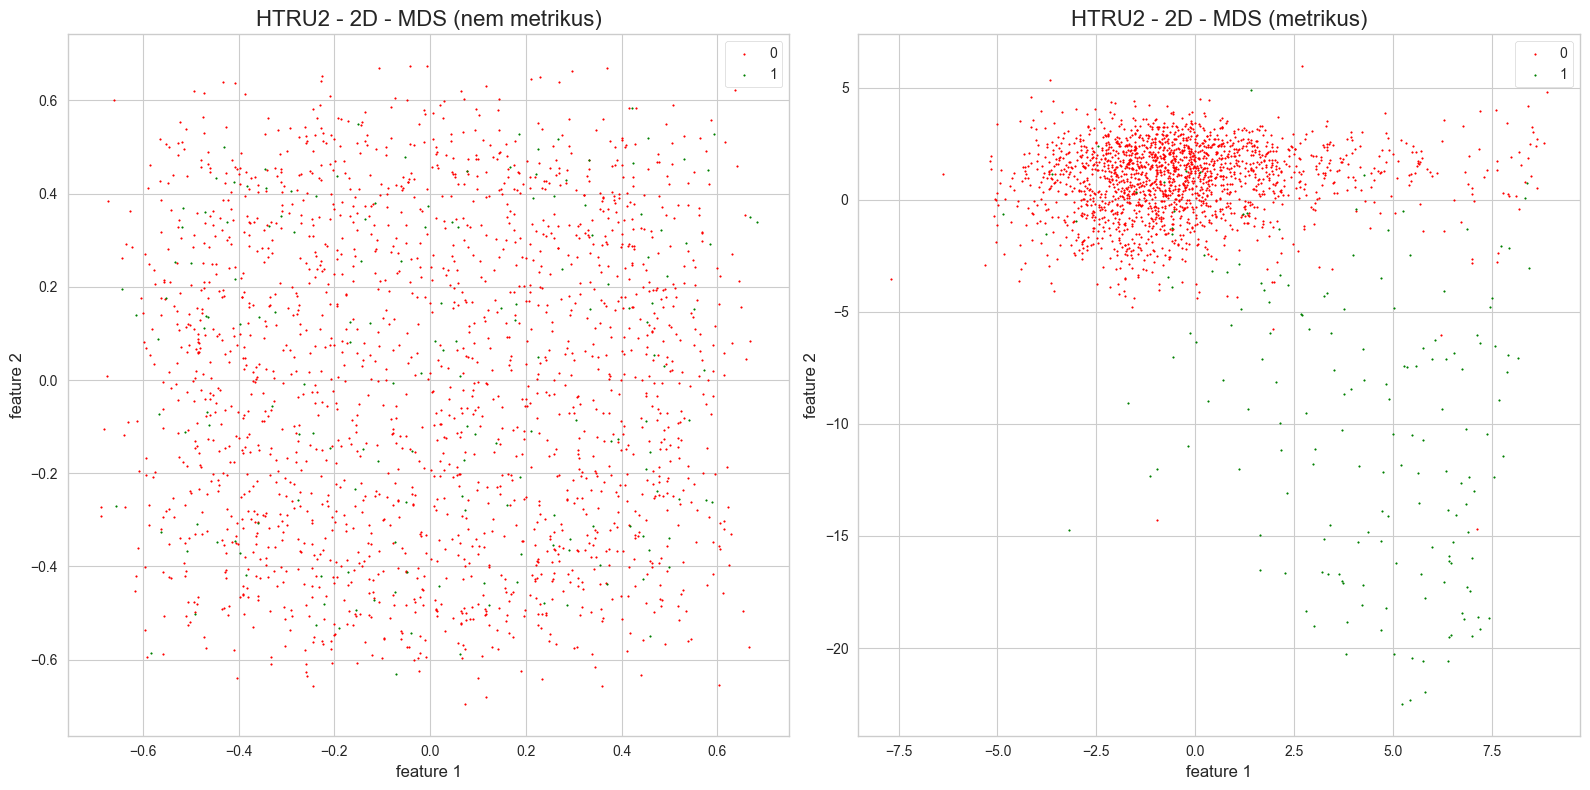

In [57]:
grafikon_scatter_2d(mds_data)

Ez számomra azért érdekes, mert a nem metrikus ábrájából semmi nem olvasható le annak ellenére, hogy a stress ott nagyságrendekkel alacsonyabb volt. A metrikus nagyon hasonlít a PCA-ra, ami az euklédeszi távolság miatt van.

# ISOMAP

In [58]:
sample_indexek = X_rbst.sample(8000, random_state=20190713).index
X_rbst_sample = X_rbst.loc[sample_indexek].reset_index(drop=True)
y_rbst_sample = y.loc[sample_indexek].reset_index(drop=True)

## 5 szomszed

In [59]:
iso_eucl = Isomap(n_components=2, n_neighbors=5, metric='sqeuclidean')
X_iso_rbst_eucl = iso_eucl.fit_transform(X_rbst_sample)

In [60]:
iso_manh = Isomap(n_components=2, n_neighbors=5, metric='manhattan')
X_iso_rbst_manh = iso_manh.fit_transform(X_rbst_sample)

In [61]:
iso_mbis = Isomap(n_components=2, n_neighbors=5, metric='mahalanobis', metric_params={'V': np.cov(X_rbst_sample.T)})
X_iso_rbst_mbis = iso_mbis.fit_transform(X_rbst_sample)

In [62]:
X_iso_euclidean = pd.DataFrame(data = X_iso_rbst_eucl, columns = ['sqeuclidean5 1', 'sqeuclidean5 2'])
X_iso_manhattan = pd.DataFrame(data = X_iso_rbst_manh, columns = ['manhattan5 1', 'manhattan5 2'])
X_iso_mahalanobis = pd.DataFrame(data = X_iso_rbst_mbis, columns = ['mahalanobis5 1', 'mahalanobis5 2'])
X_2dim_iso_5 = pd.concat([X_iso_euclidean, X_iso_manhattan, X_iso_mahalanobis], axis = 1)

## 20 szomszed

In [63]:
iso_eucl = Isomap(n_components=2, n_neighbors=20, metric='sqeuclidean')
X_iso_rbst_eucl = iso_eucl.fit_transform(X_rbst_sample)

In [64]:
iso_manh = Isomap(n_components=2, n_neighbors=20, metric='manhattan')
X_iso_rbst_manh = iso_manh.fit_transform(X_rbst_sample)

In [65]:
iso_mbis = Isomap(n_components=2, n_neighbors=20, metric='mahalanobis', metric_params={'V': np.cov(X_rbst_sample.T)})
X_iso_rbst_mbis = iso_mbis.fit_transform(X_rbst_sample)

In [66]:
X_iso_euclidean = pd.DataFrame(data = X_iso_rbst_eucl, columns = ['sqeuclidean20 1', 'sqeuclidean20 2'])
X_iso_manhattan = pd.DataFrame(data = X_iso_rbst_manh, columns = ['manhattan20 1', 'manhattan20 2'])
X_iso_mahalanobis = pd.DataFrame(data = X_iso_rbst_mbis, columns = ['mahalanobis20 1', 'mahalanobis20 2'])
X_2dim_iso_20 = pd.concat([X_iso_euclidean, X_iso_manhattan, X_iso_mahalanobis], axis = 1)

## 50 szomszéd

In [67]:
iso_eucl = Isomap(n_components=2, n_neighbors=50, metric='sqeuclidean')
X_iso_rbst_eucl = iso_eucl.fit_transform(X_rbst_sample)

In [68]:
iso_manh = Isomap(n_components=2, n_neighbors=50, metric='manhattan')
X_iso_rbst_manh = iso_manh.fit_transform(X_rbst_sample)

In [69]:
iso_mbis = Isomap(n_components=2, n_neighbors=50, metric='mahalanobis', metric_params={'V': np.cov(X_rbst_sample.T)})
X_iso_rbst_mbis = iso_mbis.fit_transform(X_rbst_sample)

In [70]:
X_iso_euclidean = pd.DataFrame(data = X_iso_rbst_eucl, columns = ['sqeuclidean50 1', 'sqeuclidean50 2'])
X_iso_manhattan = pd.DataFrame(data = X_iso_rbst_manh, columns = ['manhattan50 1', 'manhattan50 2'])
X_iso_mahalanobis = pd.DataFrame(data = X_iso_rbst_mbis, columns = ['mahalanobis50 1', 'mahalanobis50 2'])
X_2dim_iso_50 = pd.concat([X_iso_euclidean, X_iso_manhattan, X_iso_mahalanobis], axis = 1)

In [71]:
osszes = pd.concat([X_2dim_iso_5, X_2dim_iso_20, X_2dim_iso_50, y_rbst_sample], axis=1)

In [72]:
iso_data = { "data" : osszes, "x_label" : "feature 1", "y_label" : "feature 2",
        "figs" : [
            {"id": 0, "method": "Isomap 5 szomszéd", "msg": "sqeuclidean", "x": "sqeuclidean5 1", "y": "sqeuclidean5 2"},
            {"id": 1, "method": "Isomap 5 szomszéd", "msg": "manhattan", "x": "manhattan5 1", "y": "manhattan5 2"},
            {"id": 2, "method": "Isomap 5 szomszéd", "msg": "mahalanobis", "x": "mahalanobis5 1", "y": "mahalanobis5 2"},
            {"id": 3, "method": "Isomap 10 szomszéd", "msg": "sqeuclidean", "x": "sqeuclidean20 1", "y": "sqeuclidean20 2"},
            {"id": 4, "method": "Isomap 10 szomszéd", "msg": "manhattan", "x": "manhattan20 1", "y": "manhattan20 2"},
            {"id": 5, "method": "Isomap 10 szomszéd", "msg": "mahalanobis", "x": "mahalanobis20 1", "y": "mahalanobis20 2"},
            {"id": 6, "method": "Isomap 15 szomszéd", "msg": "sqeuclidean", "x": "sqeuclidean50 1", "y": "sqeuclidean50 2"},
            {"id": 7, "method": "Isomap 15 szomszéd", "msg": "manhattan", "x": "manhattan50 1", "y": "manhattan50 2"},
            {"id": 8, "method": "Isomap 15 szomszéd", "msg": "mahalanobis", "x": "mahalanobis50 1", "y": "mahalanobis50 2"}
        ]}

## Eredmények összehasonlítása

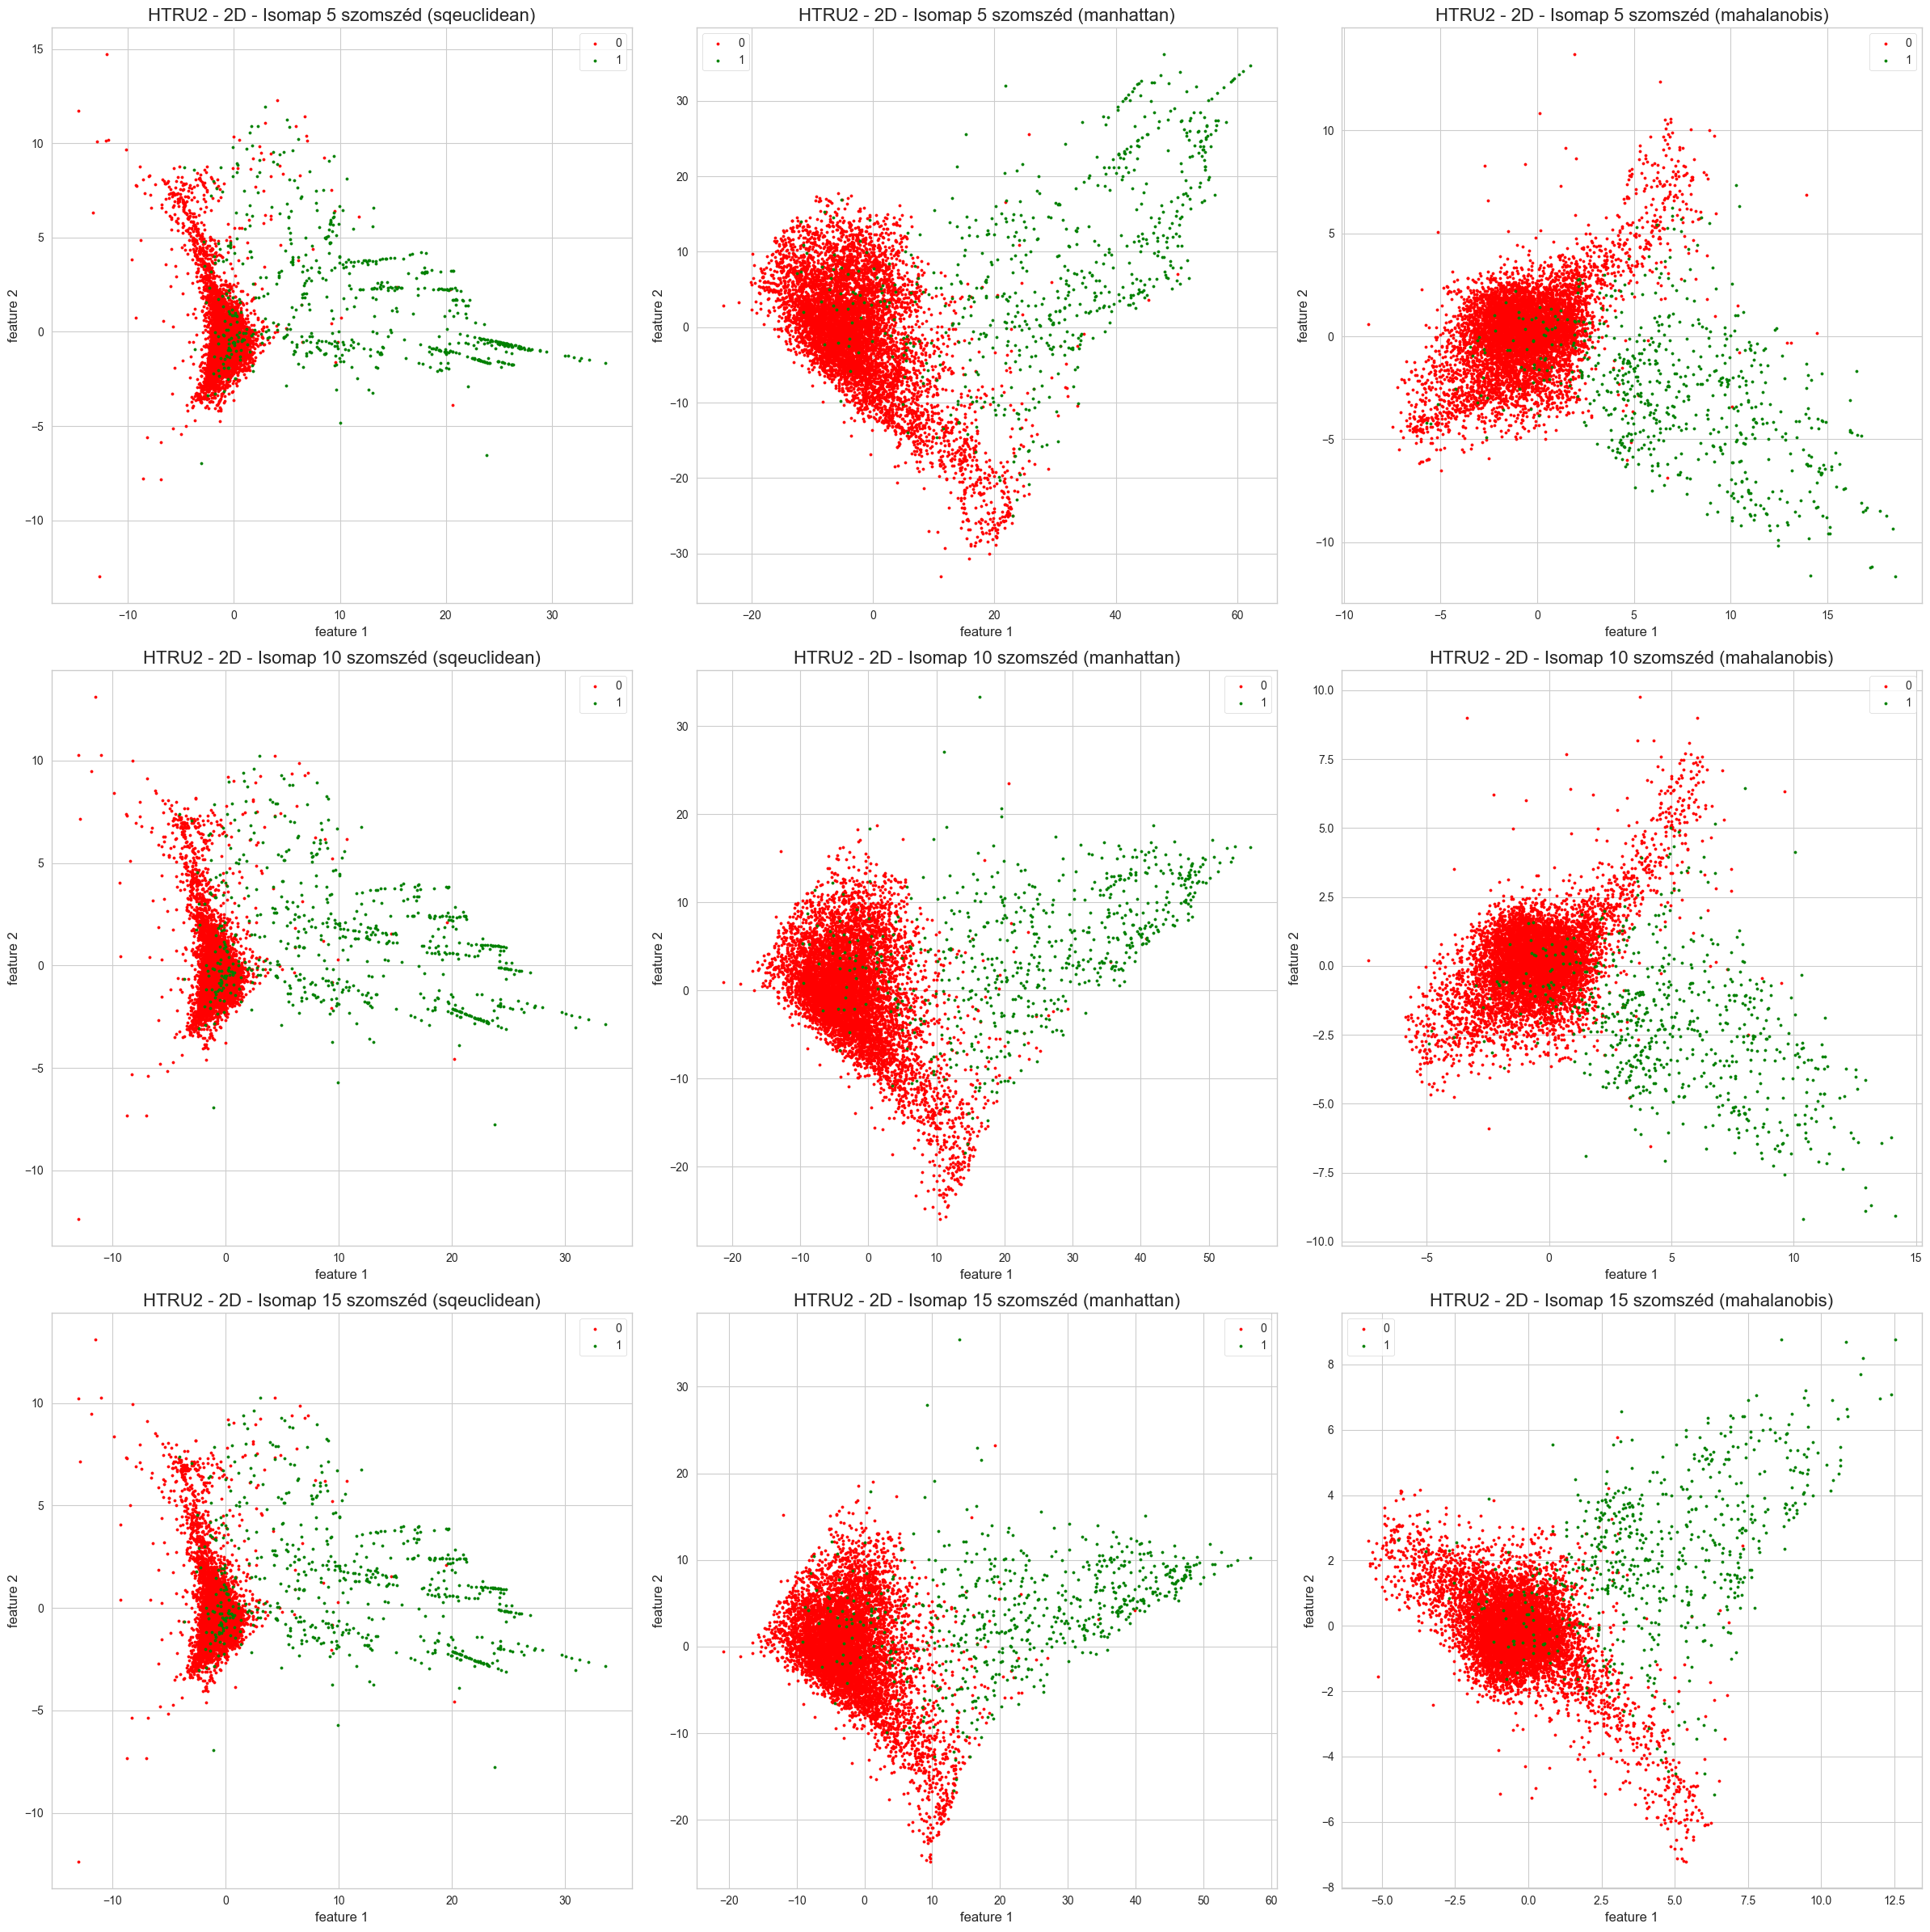

In [73]:
grafikon_scatter_2d(iso_data, 3, 5)

Számomra talán ezek közül a manhattan távolsággal mért a legértelmezhetőbb. Ahol csak 5 szomszédot vizsgáltam, ott a zöld "nyúlványok" még nagyon különböző irányokba szerte ágaznak, és a pirosak is sokkal töredezettebb csoportokat mutatnak mint a több szomszéddal számoltaknál. Gondolom azért mert az adathalmaz egyes részein a lokális jellemzők eltérést mutatnak.

Amikor már 20 szomszéddal vizsgáltam, akkor a zöld klaszter azon elemei amik távolabb vannak a pirostól sokkal jobban egy irányba, össze tartanak, mintegy háromszöget kialakítva, a globális jellemzők figyelembevétele miatt.

Az 50 szomszéd esetén már szerintem nagyon erősen érvényesülnek a globális jellemzők a lokálisat elnyomva, mindkét halmaz, a piros és a zöld is sokkal jobban egyben van mint 5-20 szomszéd esetén.

Mindezek ellenére ha klaszterezni kellene valószínűleg a 20 vagy esetleg még a 20 és 5 közötti szomszédot választanék, hogy a lokális jellemzők ne legyenek ennyire elnyomva.

A fent leírt megfigyelések a mahalanobis távolság esetén is megfigyelhetőek, a zöld klaszter egyre inkább egy háromszöget alakít ki a szomszédszám növelésével és a háromszög csúcsa egyre távolabb kerül a piros klasztertől. A problémám nekem itt az, hogy nagyobb átfedést látok a piros és a zöld csoportok közt.

A manhattan távolság két dimenziós ábrázolása nagyon-nagyon hasonlít a pca ábráira. Mivel a PCA lineáris módszer az ISOMAP pedig nem ezért gondolom, hogy a manifoldos szerkezet nem elég erős az adathalmaz esetében, nem görbül eléggé, vagy nem bonyolult eléggé, hogy mást tudjon mutatni. Ez azt erősíti emg bennem, hogy a lineáris módszerek megfelelőek az adatszerkezethez.

# LLE

In [81]:
lle_5 = LocallyLinearEmbedding(n_neighbors=5, n_components=2, method="standard", eigen_solver="auto", random_state=20190713)
lle_10 = LocallyLinearEmbedding(n_neighbors=10, n_components=2, method="standard", eigen_solver="auto", random_state=20190713)
lle_15 = LocallyLinearEmbedding(n_neighbors=15, n_components=2, method="standard", eigen_solver="auto", random_state=20190713)
lle_25 = LocallyLinearEmbedding(n_neighbors=25, n_components=2, method="standard", eigen_solver="auto", random_state=20190713)

X_lle_5 = lle_5.fit_transform(X_rbst)
X_lle_10 = lle_10.fit_transform(X_rbst)
X_lle_15 = lle_15.fit_transform(X_rbst)
X_lle_25 = lle_25.fit_transform(X_rbst)

X_lle_df_5 = pd.DataFrame(data = X_lle_5, columns = ['lle5 1', 'lle5 2'])
X_lle_df_10 = pd.DataFrame(data = X_lle_10, columns = ['lle10 1', 'lle10 2'])
X_lle_df_15 = pd.DataFrame(data = X_lle_15, columns = ['lle15 1', 'lle15 2'])
X_lle_df_25 = pd.DataFrame(data = X_lle_25, columns = ['lle25 1', 'lle25 2'])
osszes = pd.concat([X_lle_df_5, X_lle_df_10, X_lle_df_15, X_lle_df_25, y], axis=1)

In [ ]:
iso_data = { "data" : osszes, "x_label" : "feature 1", "y_label" : "feature 2",
        "figs" : [
            {"id": 0, "method": "LLE", "msg": "5", "x": "lle5 1", "y": "lle5 2"},
            {"id": 1, "method": "LLE", "msg": "10", "x": "lle10 1", "y": "lle10 2"},
            {"id": 2, "method": "LLE", "msg": "15", "x": "lle15 1", "y": "lle15 2"},
            {"id": 3, "method": "LLE", "msg": "25", "x": "lle25 1", "y": "lle25 2"}
        ]}

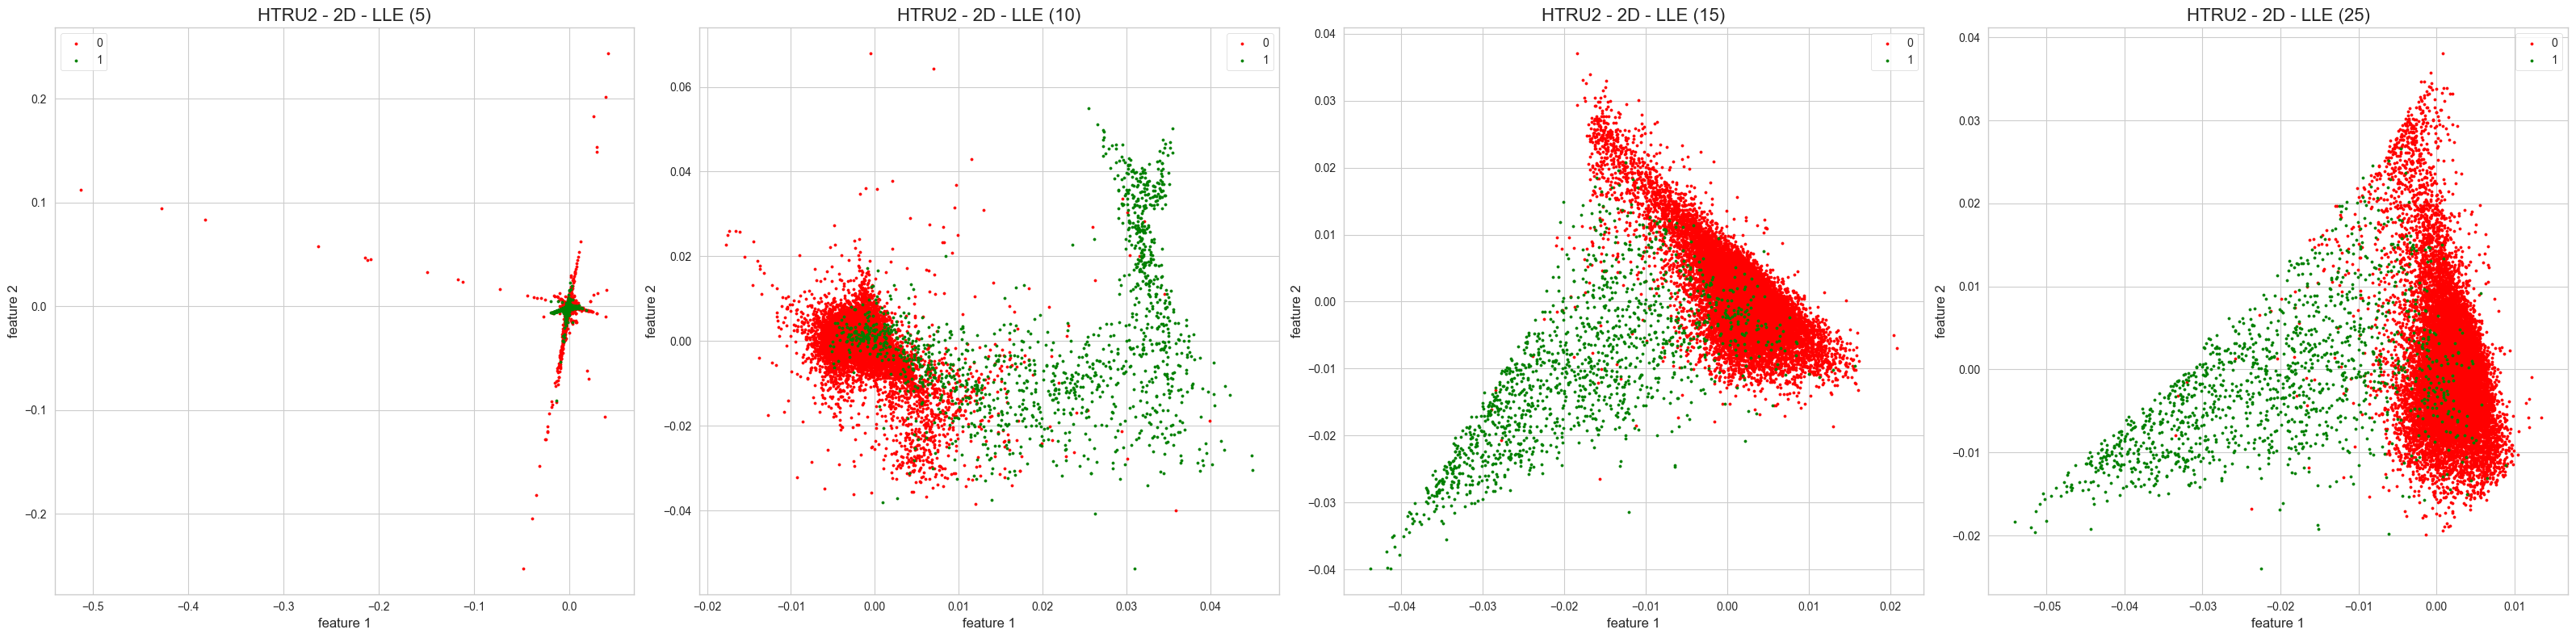

In [83]:
grafikon_scatter_2d(iso_data, 1, 5)

Az LLE ebben esetben nagyon érzékeny a bemeneti paraméterekre, a figyelembe vett szomszédok számának változtatása nagy mértékben hatással van az eredményre. Az 5 szomszéd esetében a klaszterek nagyon egymáson vannak, de 10 szomszédnál már szépen elkülönülnek. 15 szomszéd esetében a PCA és az ISOMAP esetében is látott háromszög is megjelenik a zöld klaszternél és a pirosak is a korábban már látott mintázathoz hasonlóan csoportosulnak.

# t-SNE

In [89]:
sample_indexek = X_rbst.sample(4000, random_state=20190713).index
X_rbst_sample = X_rbst.loc[sample_indexek].reset_index(drop=True)
y_rbst_sample = y.loc[sample_indexek].reset_index(drop=True)

In [93]:
X_2dim_tsne = y_rbst_sample.copy()
tsne_data = { "data" : None, "x_label" : "feature 1", "y_label" : "feature 2",
            "figs" : [
            ]}
x = 0
metrics = ['euclidean', 'sqeuclidean', 'manhattan']
perplexities = [5, 50, 100]
for metric in metrics:
    for i in perplexities:
        x += 1
        tsne = TSNE(n_components=2, perplexity=i, max_iter=500, verbose=1, metric=metric)
        X_tsne = tsne.fit_transform(X_rbst_sample)
        X_tsne = pd.DataFrame(data = X_tsne, columns = [f'{metric} komponens{i} 1', f'{metric} komponens{i} 2'])
        X_2dim_tsne = pd.concat([X_2dim_tsne, X_tsne], axis = 1)
        figdata = {"id": x, "method": "t-SNE", "msg": f"{metric} perplexity {i}", "x": f"{metric} komponens{i} 1", "y": f"{metric} komponens{i} 2"}
        tsne_data["figs"].append(figdata)

tsne_data["data"] = X_2dim_tsne


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.011s...
[t-SNE] Computed neighbors for 4000 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.252589
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.432343
[t-SNE] KL divergence after 500 iterations: 1.743737
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.488563


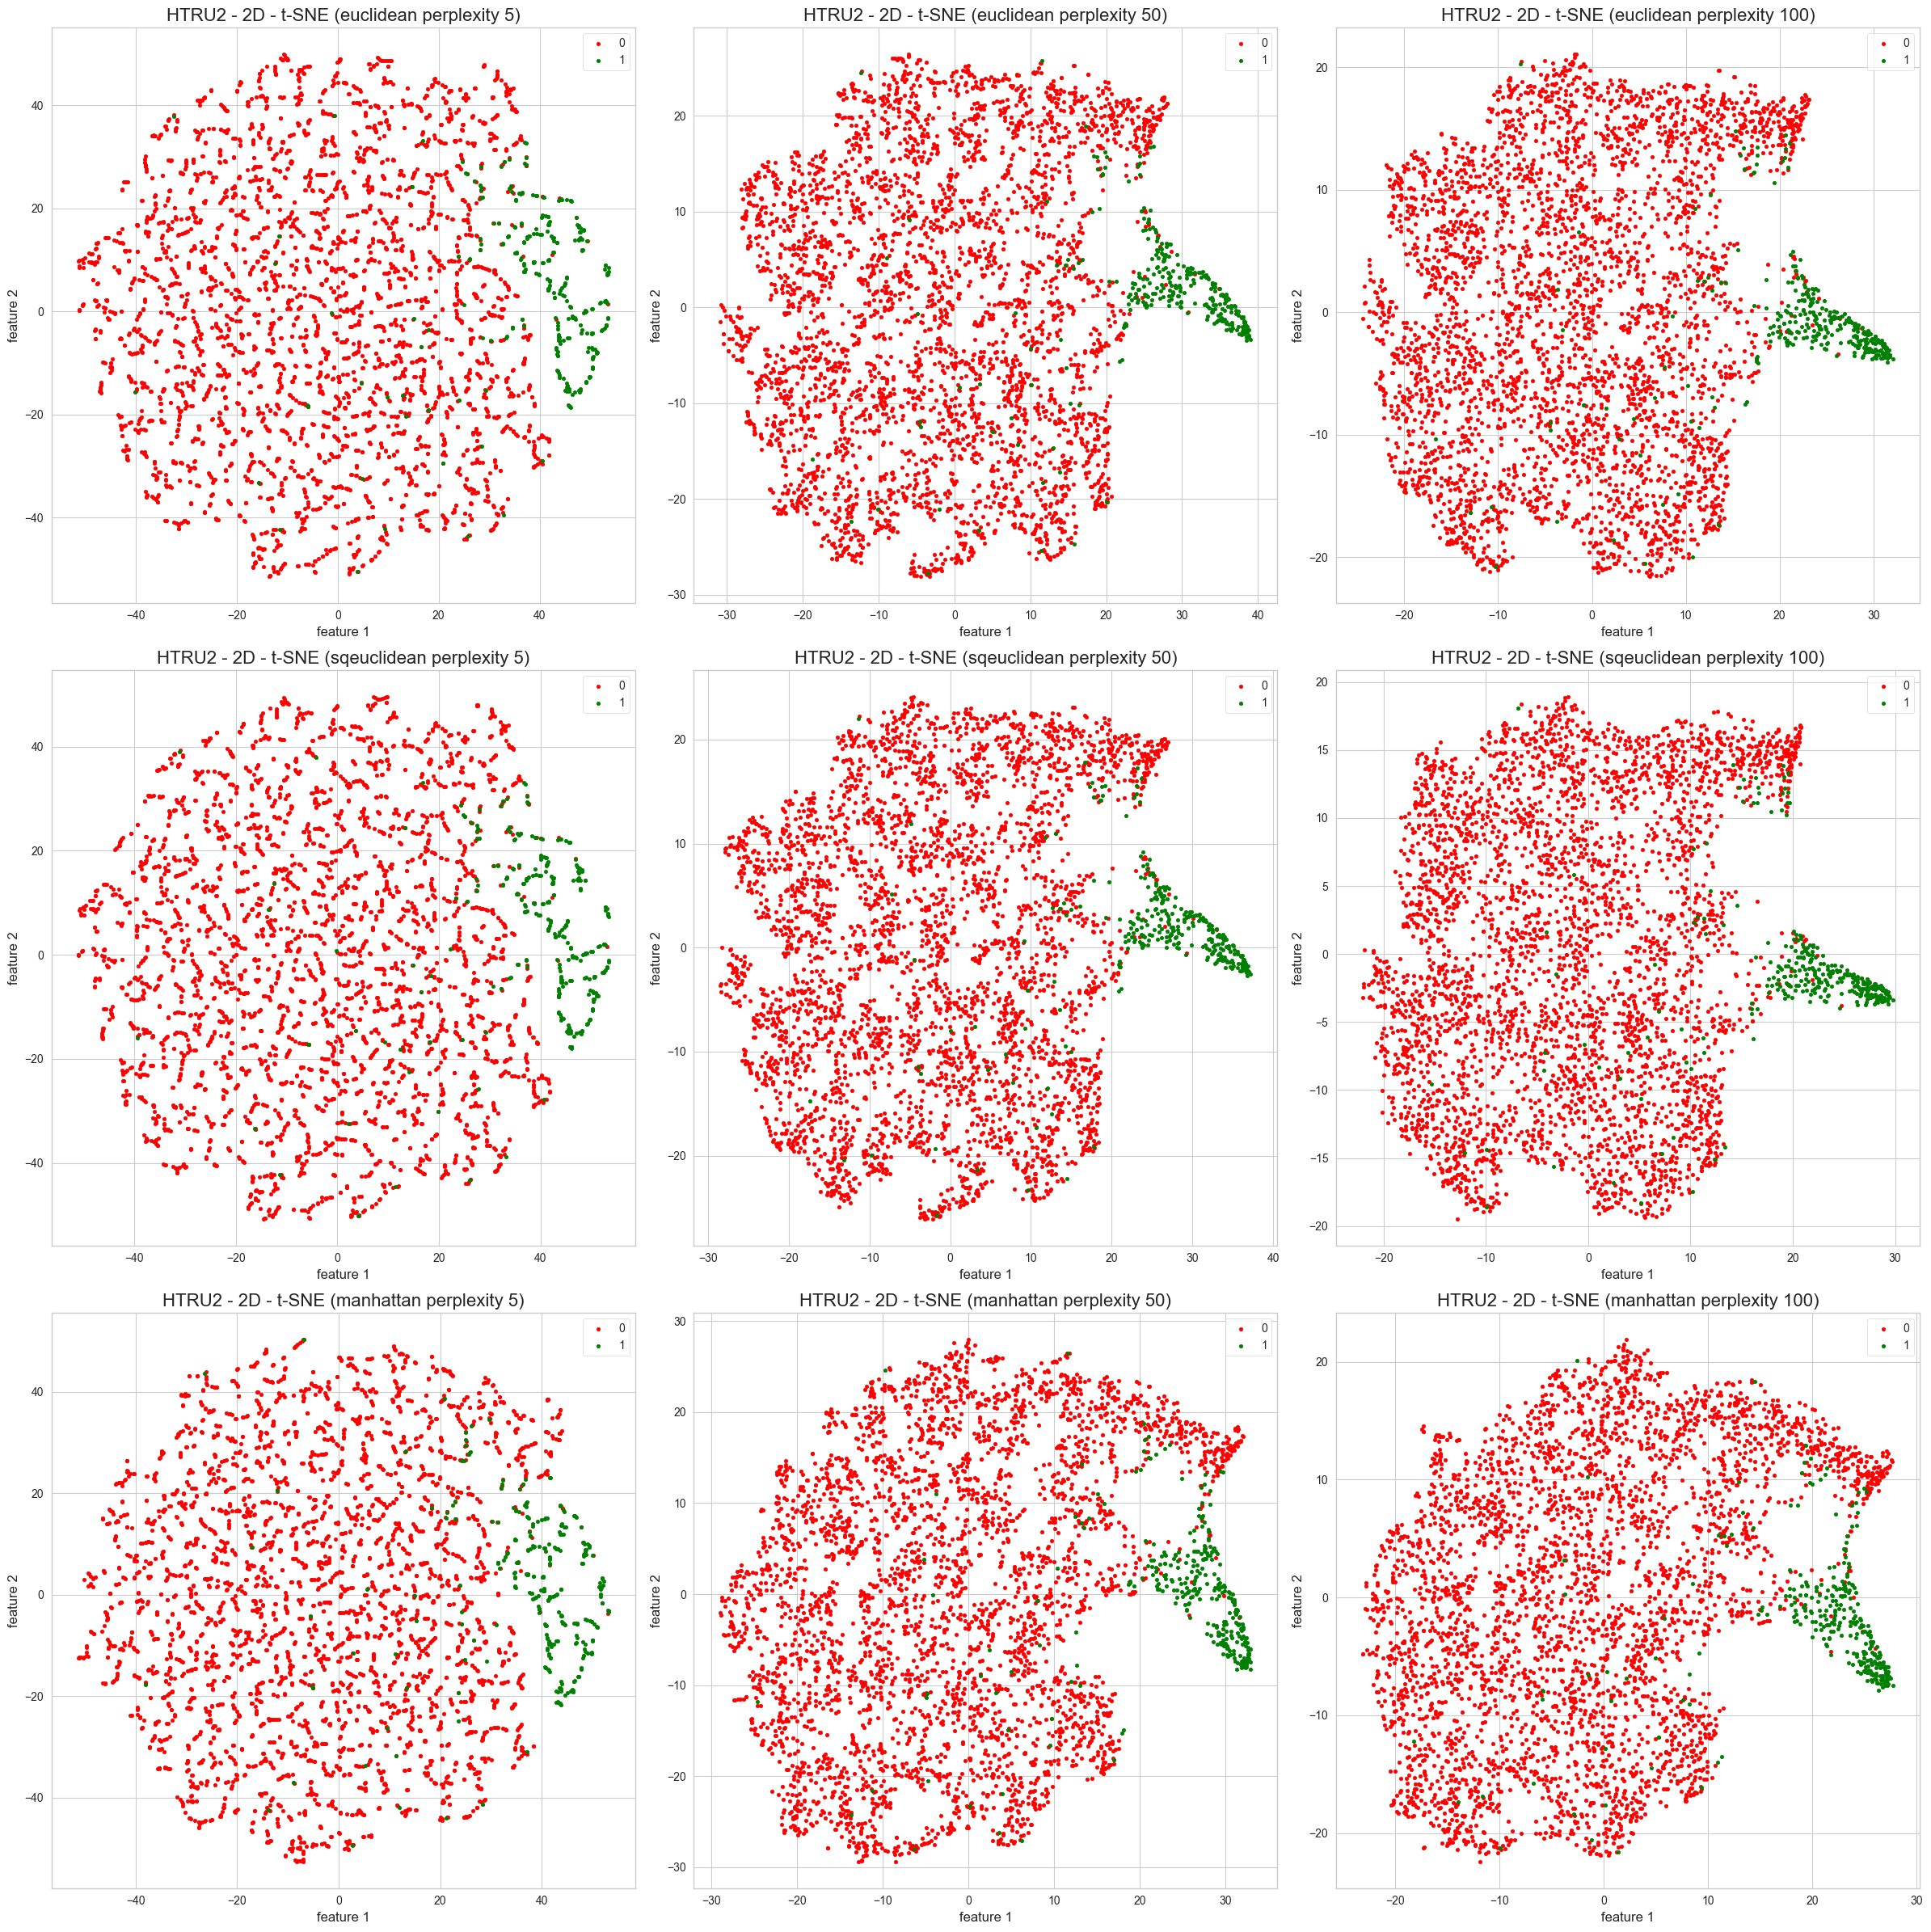

In [94]:
grafikon_scatter_2d(tsne_data, len(metrics), 10)

Nagyon sokféle paraméterrel kipróbáltam, de a tananyagban látott nagyon változatos, gyakorlatilag teljesen eltérő mintázatokat sehogyan nem sikerült előidézni. A kapott mintákban azonban a zöld klaszter főleg magas perplexity értékkel nagyon szépen elkülönül egy csoportba.

# UMAP

In [123]:
X_umap = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2).fit_transform(X_rbst)

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [124]:
X_umap = pd.DataFrame(data = X_umap, columns = ['umap 1', 'umap 2'])
X_umap = pd.concat([X_umap, y], axis = 1)

In [125]:
umap_data = { "data" : X_umap, "x_label" : "feature 1", "y_label" : "feature 2",
        "figs" : [
            {"id": 0, "method": "UMAP", "msg": "5 szomszed", "x": "umap 1", "y": "umap 2"}
        ]}

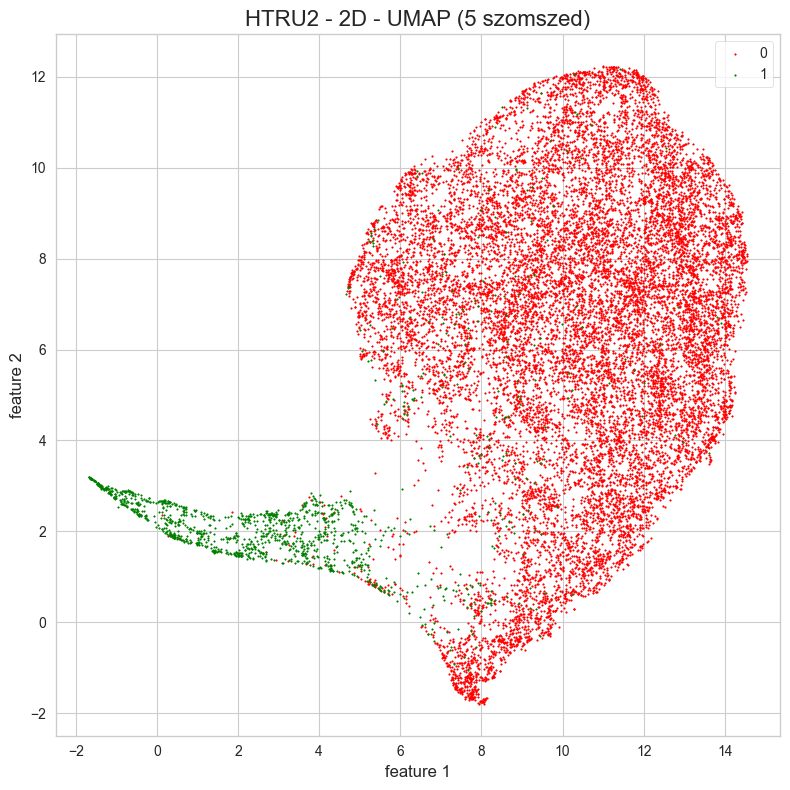

In [126]:
grafikon_scatter_2d(umap_data)

Végezetül a tananyag végén említett linken bemutatott UMAP-et is kipróbáltam. Többféle paraméter kipróbálása után végül a fenti eredményt sikerült elérnem, amin szerintem nagyon jól látszik, ahogy a két tulajdonság alapján elkülönülnek a klaszterek. A metódus nagy előnye, hogy nagyon gyorsan futott.

# K-MEANS

In [128]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=30, max_iter=300)
kmeans = kmeans.fit(X)

In [130]:
kmeans_labels = kmeans.predict(X)

In [131]:
from sklearn import metrics

print("Silhouette Coefficient: {:.5f}".format(metrics.silhouette_score(X, kmeans_labels)))
# [-1, 1] -1: rossz kalszterezési eredmény; 0: átfedő klaszterek; 1 jó klaszterezési eredmény

print("Davies-Bouldin Index: {:.5f}".format(metrics.davies_bouldin_score(X, kmeans_labels)))
# az alacsonyabb értékek jobban szeparált klaszetereket jelentenek

print("Calinski-Harabasz Index: {:.5f}".format(metrics.calinski_harabasz_score(X, kmeans_labels)))
#minél magasabb az érték, annál sűrűbbek és jól szeparáltak a klaszterek

Silhouette Coefficient: 0.51947
Davies-Bouldin Index: 0.74450
Calinski-Harabasz Index: 19564.32131


In [134]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=30, max_iter=300)
kmeans = kmeans.fit(X_std)
kmeans_labels = kmeans.predict(X_std)
print("Silhouette Coefficient: {:.5f}".format(metrics.silhouette_score(X_std, kmeans_labels)))
print("Davies-Bouldin Index: {:.5f}".format(metrics.davies_bouldin_score(X_std, kmeans_labels)))
print("Calinski-Harabasz Index: {:.5f}".format(metrics.calinski_harabasz_score(X_std, kmeans_labels)))

Silhouette Coefficient: 0.56995
Davies-Bouldin Index: 0.98000
Calinski-Harabasz Index: 11266.39450


In [135]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=30, max_iter=300)
kmeans = kmeans.fit(X_rbst)
kmeans_labels = kmeans.predict(X_rbst)
print("Silhouette Coefficient: {:.5f}".format(metrics.silhouette_score(X_rbst, kmeans_labels)))
print("Davies-Bouldin Index: {:.5f}".format(metrics.davies_bouldin_score(X_rbst, kmeans_labels)))
print("Calinski-Harabasz Index: {:.5f}".format(metrics.calinski_harabasz_score(X_rbst, kmeans_labels)))

Silhouette Coefficient: 0.72926
Davies-Bouldin Index: 0.51893
Calinski-Harabasz Index: 18234.59796


In [138]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=30, max_iter=300)
kmeans = kmeans.fit(pca_df)
kmeans_labels = kmeans.predict(pca_df)
print("Silhouette Coefficient: {:.5f}".format(metrics.silhouette_score(pca_df, kmeans_labels)))
print("Davies-Bouldin Index: {:.5f}".format(metrics.davies_bouldin_score(pca_df, kmeans_labels)))
print("Calinski-Harabasz Index: {:.5f}".format(metrics.calinski_harabasz_score(pca_df, kmeans_labels)))

Silhouette Coefficient: 0.44606
Davies-Bouldin Index: 0.79254
Calinski-Harabasz Index: 8.88621


In [148]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=50, max_iter=1000)
kmeans = kmeans.fit(X_umap)
kmeans_labels = kmeans.predict(X_umap)
print("Silhouette Coefficient: {:.5f}".format(metrics.silhouette_score(X_umap, kmeans_labels)))
print("Davies-Bouldin Index: {:.5f}".format(metrics.davies_bouldin_score(X_umap, kmeans_labels)))
print("Calinski-Harabasz Index: {:.5f}".format(metrics.calinski_harabasz_score(X_umap, kmeans_labels)))

Silhouette Coefficient: 0.40762
Davies-Bouldin Index: 1.02991
Calinski-Harabasz Index: 12951.95821


In [145]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=50, max_iter=500)
kmeans = kmeans.fit(X_lle_df_15)
kmeans_labels = kmeans.predict(X_lle_df_15)
print("Silhouette Coefficient: {:.5f}".format(metrics.silhouette_score(X_lle_df_15, kmeans_labels)))
print("Davies-Bouldin Index: {:.5f}".format(metrics.davies_bouldin_score(X_lle_df_15, kmeans_labels)))
print("Calinski-Harabasz Index: {:.5f}".format(metrics.calinski_harabasz_score(X_lle_df_15, kmeans_labels)))

Silhouette Coefficient: 0.69351
Davies-Bouldin Index: 0.54059
Calinski-Harabasz Index: 10602.44897
